 # Smart velocity analysis : mapping CMPs to velocity logs in laterally smooth media

In [1]:
# cell with imports
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import subprocess
import time
import matplotlib
matplotlib.rc('image', cmap='RdBu_r')
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 5]

import numpy as np
# madagascar API
import m8r as sf
# learning
import keras
import tensorflow as tf
# images
from IPython import get_ipython
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from skimage.transform import resize

# execution flags
generate_rsf_data_flag = True
add_data = False


Using TensorFlow backend.


## Introduction

### Why?
FWI provides high resolution models, yet it is very computationally expensive and it can fail with the lack of low frequencies. 

Velocity analysis is on the other hand very cheap computationally, but limited by the assumptions on the background medium.

### Goal
Combine advantages of both methods with deep learning

### Solution
We will train a deep convolutional neural network to perform velocity analysis in inhomogeneous media

We estimate velocity $v(x_{CMP}, z)$ from presure field
 $p_{obs}(x_{CMP}-\varepsilon:x_{CMP}+\varepsilon, 0:h_{max}, f)$, where
 $x_{CMP}$ is the central midpoint,
 $p_{obs}$ is the observed pressure.
 
$\varepsilon = 0$ in this first part of the application => single CMP as input

## Method

0) generate a model set

1) generate seismic data set

2) build neural network

3) train neural network

4) test it on a model that it has not seen

In [2]:
# Utilities
# to use Madagascar from command line
dx = 50

def cmd(command):
    """Run command and pipe what you would see in terminal into the output cell
    """
    process = subprocess.Popen(command, stderr=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
    while True:
        output = process.stderr.readline().decode('utf-8')
        if output == '' and process.poll() is not None:
            # this prints the stdout in the end
            output2 = process.stdout.read().decode('utf-8')
            print(output2.strip())
            break
        if output:
            print(output.strip())
    rc = process.poll()
    return rc

def plt_nb_T(vel, fname="Velocity", title="Velocity (km/s)",
             ylabel="Depth (km)", xlabel="Distance (km)",
             vmin=None, vmax=None,
             dx=dx, dz=dx, no_labels=False, origin_in_middle=False):
    plt.figure(figsize=(16,9))
    vel_image = vel[:,:].T
    extent=(0, dx * vel.shape[0] * 1e-3, dz * vel.shape[1] *1e-3, 0)
    if origin_in_middle:
        extent = (-dx * vel.shape[0] * .5e-3, dx * vel.shape[0] * .5e-3, dz * vel.shape[1] *1e-3, 0)
    plt.imshow(vel_image * 1e-3, origin='upper', extent=extent)
    plt.axis("tight")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.clim(vmin,vmax)
    plt.colorbar()
    if no_labels:
        plt.axis('off')
        plt.xlabel()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
    
def plt_nb_strip(vel, fname="Velocity", title="Velocity (km/s)",
             ylabel="Depth (km)", xlabel="Distance (km)",
             dx=dx, dz=dx, no_labels=False, origin_in_middle=False, x_samples=200):
    plt_nb_T(vel[:x_samples,:], fname=fname, title=title,
             ylabel=ylabel, xlabel=xlabel,
             dx=dx, dz=dz, no_labels=no_labels, origin_in_middle=origin_in_middle,)

## Model generation

we utilize common deep learning image augmentation technique -- elastic transform

code first:

In [3]:
# to distort the model
def elastic_transform(image, alpha, sigma, random_state_number=None, v_dx=dx, plot_name=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
  
    random_state = np.random.RandomState(random_state_number)

    shape = image.shape
    print(shape)
    
    # with our velocities dx is vertical shift
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), (10*sigma, sigma/10, 1), mode="constant", cval=0) * 4 * alpha
    #plt_nb_T(v_dx * np.squeeze(dx[:,:]), fname="VerticalShifts", title="Vertical shifts (km)")
    
    # with our velocities dy is horizontal
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), (10*sigma, sigma/10, 1),  mode="constant", cval=0) * 0.1 * alpha
    dz = np.zeros_like(dx)
    
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)),  np.reshape(z, (-1, 1))
    
    distorted_image = map_coordinates(image, indices, order=1, mode='reflect', prefilter=False)
    distorted_image = distorted_image.reshape(image.shape)
    
    if plot_name != None:
        dq_x = 50
        dq_z = 10
        M = np.hypot(dy.squeeze()[::dq_x,::dq_z].T, dx.squeeze()[::dq_x,::dq_z].T)
        M = dx.squeeze()[::dq_x,::dq_z].T
        M = np.squeeze(image)[::dq_x,::dq_z].T
        if 0:
            fig1, ax1 = plt.subplots(figsize=(16,9))
            ax1.set_title('Shifts of the model')
            plt.imshow(np.squeeze(image.T), extent=(0, v_dx * dx.shape[0] * 1e-3, v_dx * dx.shape[1] *1e-3, 0))
            plt.axis("tight")
            plt.xlabel("Distance (km)")
            plt.ylabel("Depth (km)")
            plt.colorbar()
            Q = ax1.quiver(
                1e-3*v_dx *y.squeeze()[::dq_x,::dq_z].T, 1e-3*v_dx *x.squeeze()[::dq_x,::dq_z].T, 
                1e-3*v_dx*dy.squeeze()[::dq_x,::dq_z].T, 1e-3*v_dx*dx.squeeze()[::dq_x,::dq_z].T, 
                scale_units='xy', scale=1)
            plt.savefig(f"../latex/Fig/shiftsVectors", bbox_inches='tight')
            plt.show()

        fig1, ax1 = plt.subplots(figsize=(16,9))
        ax1.set_title('Shifts of the model')
        plt.imshow(np.squeeze(distorted_image.T), extent=(0, v_dx * dx.shape[0] * 1e-3, v_dx * dx.shape[1] *1e-3, 0))
        plt.axis("tight")
        plt.xlabel("Distance (km)")
        plt.ylabel("Depth (km)")
        plt.colorbar()
        Q = ax1.quiver(
            1e-3*v_dx *y.squeeze()[::dq_x,::dq_z].T, 1e-3*v_dx *x.squeeze()[::dq_x,::dq_z].T, 
            1e-3*v_dx*dy.squeeze()[::dq_x,::dq_z].T, 1e-3*v_dx*dx.squeeze()[::dq_x,::dq_z].T, 
            scale_units='xy', scale=1, pivot='tip')
        plt.savefig(f"../latex/Fig/deformedModel{plot_name}", bbox_inches='tight')
        plt.show()

    return distorted_image

In [4]:
# Fetch data from reproducibility.org
sf.Fetch('marm','marmvel.hh')

# #%% [markdown]
#    ## Generating the model
#    First we create model by augmenting Marmousi II

def generate_model(model_input="marmvel.hh", dx=dx, 
                   file_rescaled="marm.rsf",
                   stretch_X=None,
                   distort_flag=True):
    # downscale marmousi
    #def rescale_to_dx(rsf_file_in, rsf_file_out, dx)
    model_orig = sf.Input(model_input)
    # we downscale
    scale_factor = dx / model_orig.float("d1")
    
    vel = model_orig.read()
    #print(vel.flags)
    print(np.shape(vel))
    
    if stretch_X == None:
        vel = resize(vel[:,:], (np.shape(vel)[0], np.shape(vel)[1]//scale_factor))
        print(f"Model downscaled {scale_factor} times to {dx} meter sampling \n")
    else:
        vel = resize(vel[:,:], (stretch_X*np.shape(vel)[0]//scale_factor, np.shape(vel)[1]//scale_factor))
        print(f"Model stretched {stretch_X} times to {dx} meter sampling \n")
    print(f"Writing to {file_rescaled}")
    yy = sf.Output(file_rescaled)
    #print(vel.flags)
    # we concatenate horizontally, this is confusing because of flipped axis in madagascar
    vel = np.concatenate((vel,np.flipud(vel),vel), axis = 0)
    #vel = np.concatenate((vel,np.flipud(vel),vel), axis = 0)
    #vel = np.concatenate((vel,np.flipud(vel),vel), axis = 0)

    vel = np.atleast_3d(vel)
    if distort_flag:
        vel = elastic_transform(vel, 1000, 30, random_state_number=None)
    vel = np.squeeze(vel)
    #vel = 1500 * np.ones_like(vel)
    #
     
    # this is also confusing, needs to be improved
    yy.put('n1',np.shape(vel)[1])
    yy.put('n2',np.shape(vel)[0])
    yy.put('d1',dx)
    yy.put('d2',dx)
    yy.write(vel)
    yy.close()

    return vel

## Stretch Marmousi model 12.5 times horizonrtally

(2301, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to marm.rsf


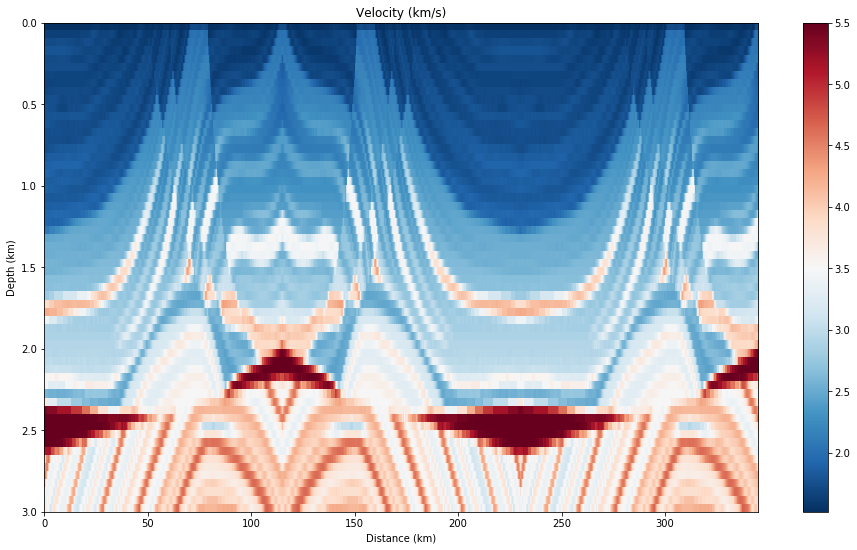

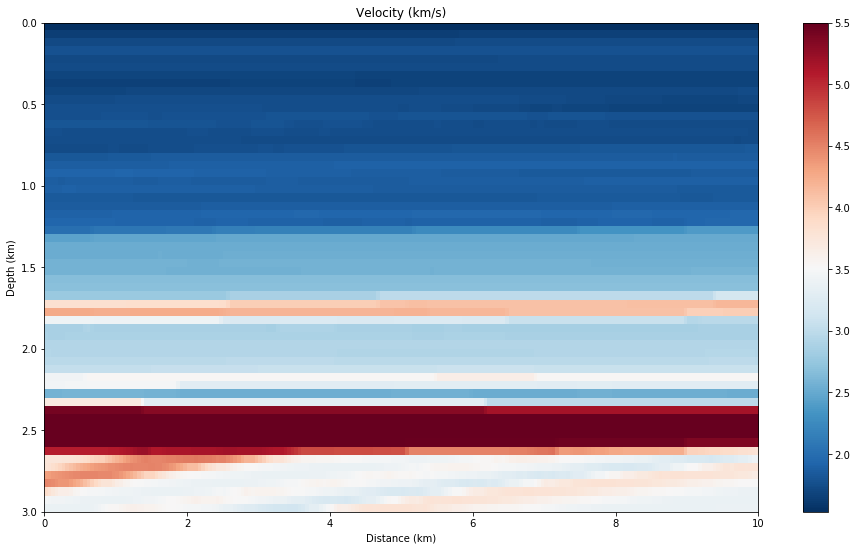

In [5]:
# Stretched Marmousi

vel = generate_model(distort_flag = False)
plt_nb_T(vel, fname="../latex/Fig/stretchMarm")
plt_nb_strip(vel, fname="../latex/Fig/stretchMarm_strip")
N = np.shape(vel)

(6903, 60, 1)


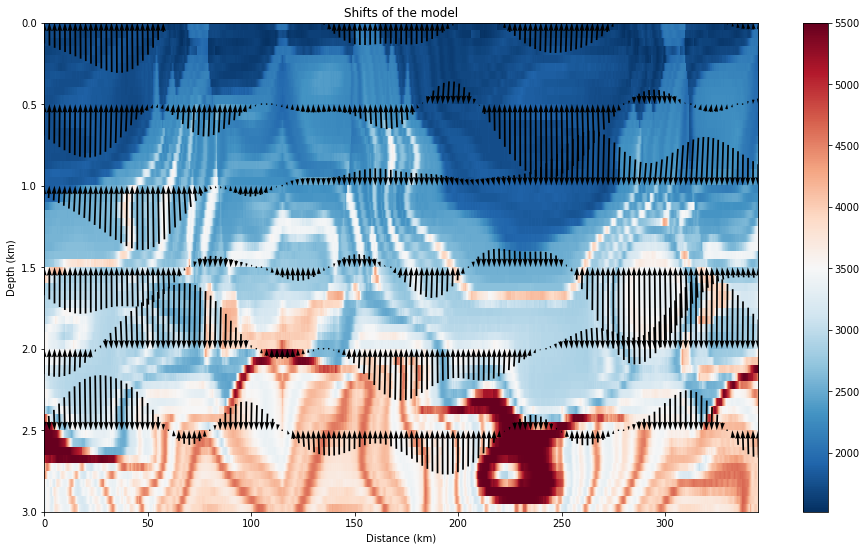

(6903, 60, 1)


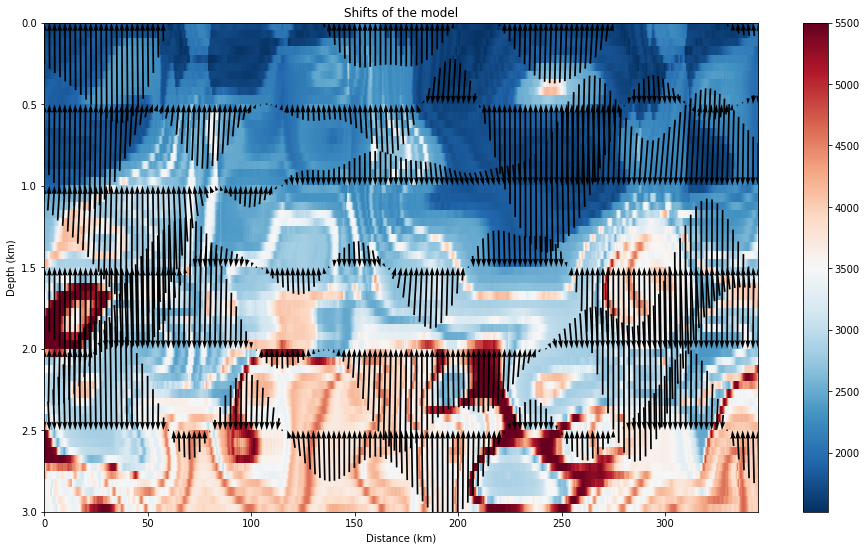

In [6]:
vel_example = elastic_transform(np.atleast_3d(vel), 500, 30, random_state_number=314, plot_name="Mild")
vel_example = elastic_transform(np.atleast_3d(vel), 1000, 30, random_state_number=314, plot_name="Normal")

## Gaussian fields to generate a coordinate shift for laterally smooth models



### Large correlation radius in horizontal direction -- to keep it almost horizontally layered

### Small correlation radius in vertical direction -- to make it represent different layering scenarios

### Same parameters but different fields for horizontal and vertical components

### Large vertical shifts and small horizontal -- to keep it laterally slowly varying

(2301, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to marm.rsf
(6903, 60, 1)


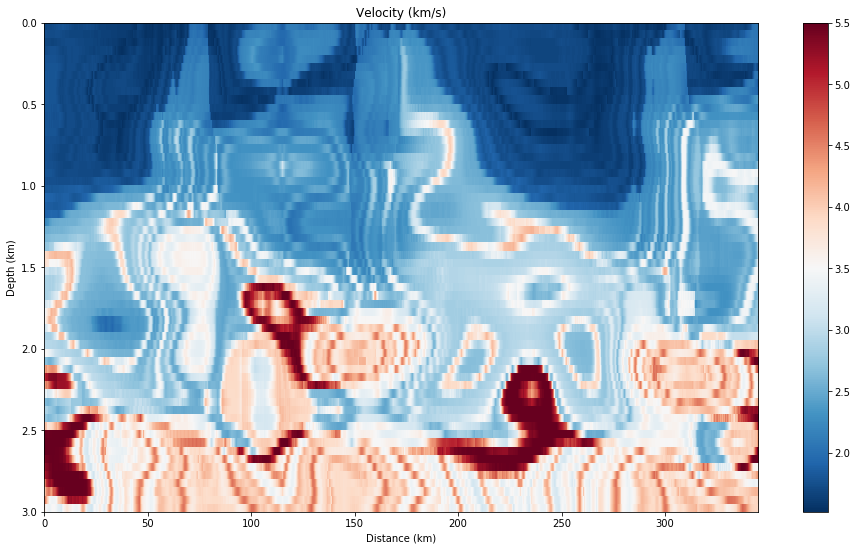

In [7]:
vel = generate_model()
plt_nb_T(vel)

## Generator features

### Laterally slowly varying models are generated

### Several layers can be generated from a single one

### Velocities are exactly the same as in mother-model (Marmousi)

## Modeling data with constant offset on GPU with Madagascar

In [8]:
# Setting up parameters
N = np.shape(vel)
dt = 0.0025
T_max = 7
nt = int(T_max / dt + 1)

print(f"number of time steps = {nt}")



# check stability
print(f"you chose dt = {dt}, dt < {dx/np.max(vel):.4f} should be chosen for stability \n")
# force stability
assert dt < dx/np.max(vel)

# ricker wavelet is roughly bounded by 3f_dominant
# therefore the sampling rate principally acceptable sampling rate would be

central_freq = 3
print(f"dt from Nyquist criterion is {1/(2*3*central_freq)}")



jgx = 2
jsx = jgx
jdt = 4

print(f"dt chosen for CNN is {jdt*dt}, which is {(1/(3*central_freq))/(jdt*dt)} samples per cycle")
sxbeg = 5000//dx
gxbeg = 1000//dx
szbeg = 2
jlogz = 2

ns = (N[0] - 2*sxbeg)//jgx 
ng = 2*(sxbeg-gxbeg)//jgx + 1



number of time steps = 2801
you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

dt from Nyquist criterion is 0.05555555555555555
dt chosen for CNN is 0.01, which is 11.11111111111111 samples per cycle


In [9]:
# model data and sort into CMPs function
def generate_rsf_data(model_name="marm.rsf", central_freq=central_freq, dt=dt, 
                        nt=nt, sxbeg=sxbeg, gxbeg=gxbeg, szbeg=szbeg, 
                        jsx=jsx, jgx=jgx, ns=ns, ng=ng, jdt=jdt,
                        logs_out="logs.rsf", shots_out="shots_cmp.rsf"): 
    print(f"Total number of shots = {ns}")
    t_start = time.time()

    cmd((f"sfgenshots < {model_name} csdgather=y fm={central_freq} amp=1 dt={dt} ns={ns} ng={ng} nt={nt} "
                            f"sxbeg={sxbeg} chk=n szbeg=2 jsx={jgx} jsz=0 gxbeg={gxbeg} gzbeg={szbeg} jgx={jgx} jgz=0 > shots.rsf"))
    print(f"Modeling time for {ns} shots = {time.time()-t_start}")
    #
    #   ## Analyze and filter the data set generated
    # cmd("sfgrey < shots.rsf | sfpen")
    # decimate in time and display
    cmd(f"sfput < shots.rsf d3={jgx*dx} > shots_corrected.rsf")
    # reduce sampling in time jdt (usually 4) times
    cmd(f"sfwindow < shots_corrected.rsf j1={jdt} > shots_decimated.rsf")
    
    #get size of the model
    model_orig = sf.Input(model_name)
    Nx = model_orig.int("n2")
    print(Nx)
    
    # sort into cmp gathers and discard odd cmps
    print(f"sfshot2cmp < shots_decimated.rsf half=n | sfwindow j3=2 min3={(-gxbeg+2*sxbeg)*dx} max3={(Nx-(2*sxbeg))*dx} > {shots_out}")
    cmd(f"sfshot2cmp < shots_decimated.rsf half=n | sfwindow j3=2 min3={(-1.5*gxbeg+1.5*sxbeg)*dx} max3={(Nx-(2.5*sxbeg-.5*gxbeg))*dx} > {shots_out}")
    # take out not full cmps
    cmd(f"sfin < {shots_out}")
    # create the logs -- training outputs
    cmd(f"sfwindow < {model_name} min2={(-gxbeg+2*sxbeg)*dx} j2={jsx} max2={(Nx-(2*sxbeg-gxbeg))*dx} > {logs_out}")
    cmd(f"sfin < {logs_out}")
    #cmd("sfgrey < {logs_out} | sfpen")

    return 0



(2301, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to marm.rsf
(6903, 60, 1)


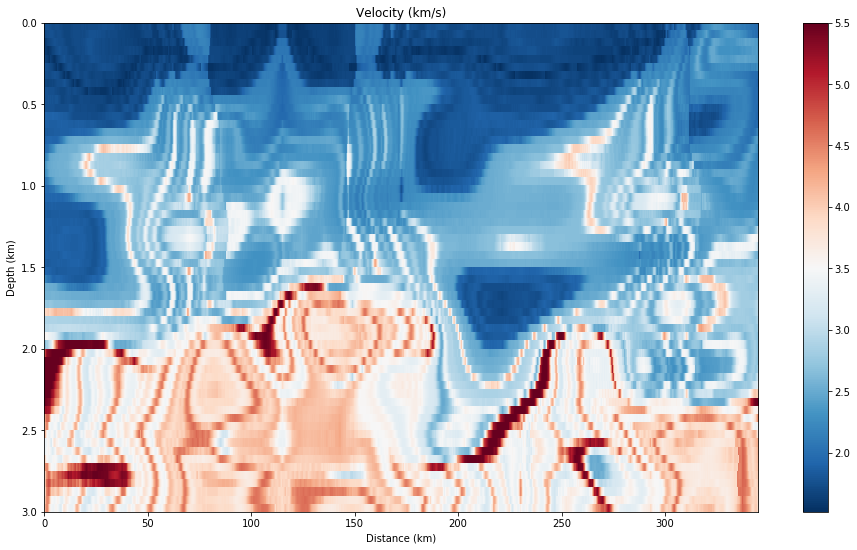

Total number of shots = 3351
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.216897 (s)
sfgenshots: shot 11 finished: 0.135333 (s)
sfgenshots: shot 21 finished: 0.134996 (s)
sfgenshots: shot 31 finished: 0.135322 (s)
sfgenshots: shot 41 finished: 0.134917 (s)
sfgenshots: shot 51 finished: 0.135378 (s)
sfgenshots: shot 61 finished: 0.134892 (s)
sfgenshots: shot 71 finished: 0.135300 (s)
sfgenshots: shot 81 finished: 0.134842 (s)
sfgenshots: shot 91 finished: 0.135384 (s)
sfgenshots: shot 101 finished: 0.134745 (s)
sfgenshots: shot 111 finished: 0.135213 (s)
sfgenshots: shot 121 finished: 0.134806 (s)
sfgenshots: shot 131 finished: 0.135534 (s)
sfgenshots: s

sfgenshots: shot 1771 finished: 0.137881 (s)
sfgenshots: shot 1781 finished: 0.138068 (s)
sfgenshots: shot 1791 finished: 0.138147 (s)
sfgenshots: shot 1801 finished: 0.137903 (s)
sfgenshots: shot 1811 finished: 0.138095 (s)
sfgenshots: shot 1821 finished: 0.137842 (s)
sfgenshots: shot 1831 finished: 0.138398 (s)
sfgenshots: shot 1841 finished: 0.138358 (s)
sfgenshots: shot 1851 finished: 0.138244 (s)
sfgenshots: shot 1861 finished: 0.138077 (s)
sfgenshots: shot 1871 finished: 0.138397 (s)
sfgenshots: shot 1881 finished: 0.138111 (s)
sfgenshots: shot 1891 finished: 0.138087 (s)
sfgenshots: shot 1901 finished: 0.138304 (s)
sfgenshots: shot 1911 finished: 0.138367 (s)
sfgenshots: shot 1921 finished: 0.138479 (s)
sfgenshots: shot 1931 finished: 0.138179 (s)
sfgenshots: shot 1941 finished: 0.138007 (s)
sfgenshots: shot 1951 finished: 0.138202 (s)
sfgenshots: shot 1961 finished: 0.138232 (s)
sfgenshots: shot 1971 finished: 0.137923 (s)
sfgenshots: shot 1981 finished: 0.137981 (s)
sfgenshots

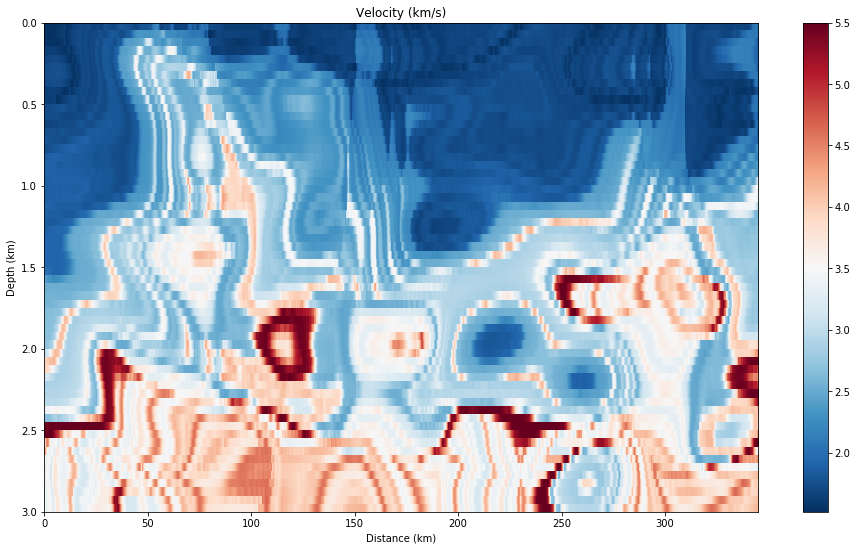

Total number of shots = 3351
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.529989 (s)
sfgenshots: shot 11 finished: 0.137756 (s)
sfgenshots: shot 21 finished: 0.136426 (s)
sfgenshots: shot 31 finished: 0.136243 (s)
sfgenshots: shot 41 finished: 0.136474 (s)
sfgenshots: shot 51 finished: 0.136186 (s)
sfgenshots: shot 61 finished: 0.136056 (s)
sfgenshots: shot 71 finished: 0.137206 (s)
sfgenshots: shot 81 finished: 0.137068 (s)
sfgenshots: shot 91 finished: 0.137335 (s)
sfgenshots: shot 101 finished: 0.136917 (s)
sfgenshots: shot 111 finished: 0.138073 (s)
sfgenshots: shot 121 finished: 0.138531 (s)
sfgenshots: shot 131 finished: 0.137336 (s)
sfgenshots: s

sfgenshots: shot 1771 finished: 0.138515 (s)
sfgenshots: shot 1781 finished: 0.138374 (s)
sfgenshots: shot 1791 finished: 0.138221 (s)
sfgenshots: shot 1801 finished: 0.138271 (s)
sfgenshots: shot 1811 finished: 0.138118 (s)
sfgenshots: shot 1821 finished: 0.138347 (s)
sfgenshots: shot 1831 finished: 0.137995 (s)
sfgenshots: shot 1841 finished: 0.138309 (s)
sfgenshots: shot 1851 finished: 0.138047 (s)
sfgenshots: shot 1861 finished: 0.138149 (s)
sfgenshots: shot 1871 finished: 0.138370 (s)
sfgenshots: shot 1881 finished: 0.137904 (s)
sfgenshots: shot 1891 finished: 0.138188 (s)
sfgenshots: shot 1901 finished: 0.138129 (s)
sfgenshots: shot 1911 finished: 0.137994 (s)
sfgenshots: shot 1921 finished: 0.138290 (s)
sfgenshots: shot 1931 finished: 0.137938 (s)
sfgenshots: shot 1941 finished: 0.138212 (s)
sfgenshots: shot 1951 finished: 0.138109 (s)
sfgenshots: shot 1961 finished: 0.138020 (s)
sfgenshots: shot 1971 finished: 0.138212 (s)
sfgenshots: shot 1981 finished: 0.137940 (s)
sfgenshots

In [10]:
# we can always append more data by setting add_data == True 
if generate_rsf_data_flag:
    for iShotBlock in range(2):
        vel=generate_model()
        plt_nb_T(vel)
        generate_rsf_data()
        if (iShotBlock == 0) and (add_data == False):
            cmd(f"sfcp < shots_cmp.rsf > shots_cmp_full.rsf")
            cmd(f"sfcp < logs.rsf > logs_full.rsf")
        else:
            cmd(f"sfcat shots_cmp_full.rsf shots_cmp.rsf axis=3 > tmp.rsf")
            cmd(f"sfmv tmp.rsf shots_cmp_full.rsf")
            cmd(f"sfcat logs_full.rsf logs.rsf axis=2 > tmp.rsf")
            cmd(f"sfmv tmp.rsf logs_full.rsf")


## Read data into numpy and check that the number of logs is the same as number of shots

(6546, 21, 701, 1)
(6546, 30)


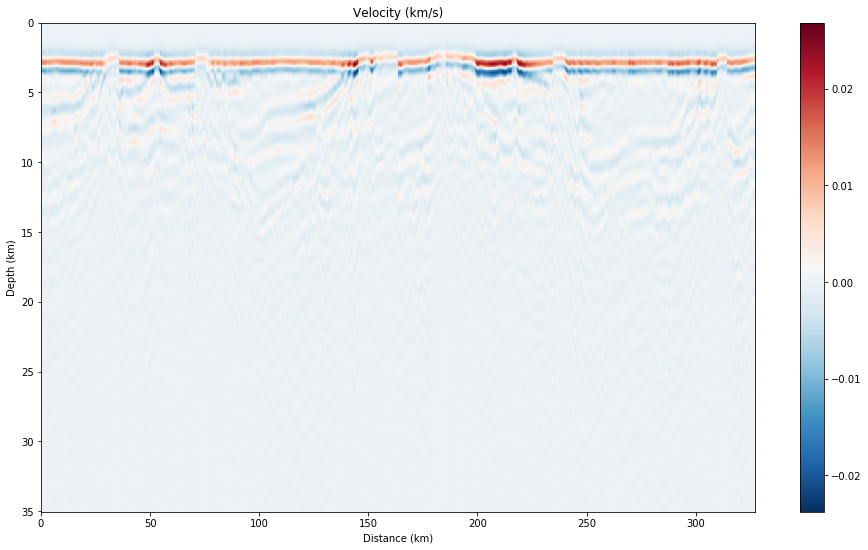

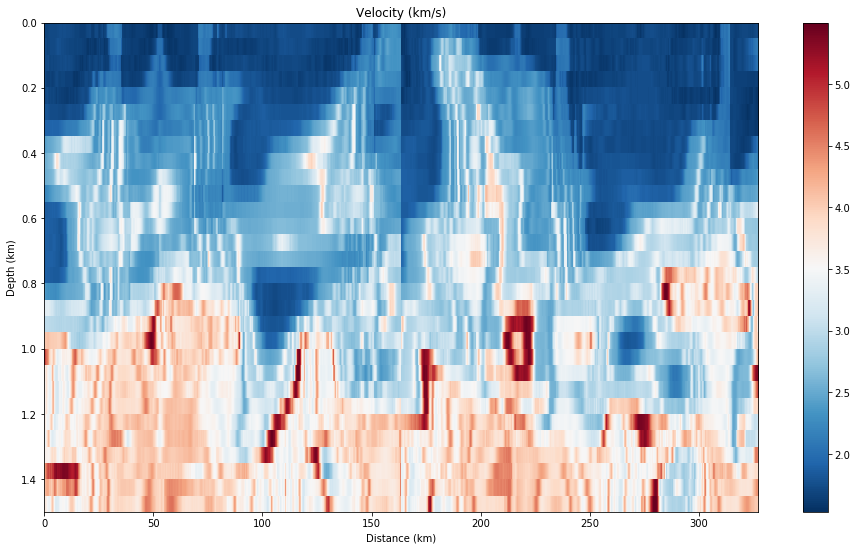

In [11]:
def read_rsf_to_np(shots_rsf='shots_cmp_full.rsf', logs_rsf='logs_full.rsf',
                  n_offsets=None, j_log_z=jlogz):
    shots_cmp = sf.Input(shots_rsf)
    X_data = shots_cmp.read()
    
    if n_offsets==None :
        X_data = X_data[:,:(np.shape(X_data)[1] + 1) // 2,:]
    
    X_data = np.expand_dims(X_data, axis=3)
    X_size = np.shape(X_data)
    #image = plt.imshow(X_data[0,:,:].squeeze())
    #plt.show()
    print(X_size)
    logs = sf.Input(logs_rsf)
    T_data = logs.read()
    
    # decimate logs in vertical direction --2 times by default
    T_data = resize(T_data, (np.shape(T_data)[0], np.shape(T_data)[1] // j_log_z))
    T_size = np.shape(T_data)
    print(T_size)

    # ensure that the number of logs is equal to the number of CMPs
    assert (X_size[0] == T_size[0])
    return X_data, T_data

X_data, T_data = read_rsf_to_np(shots_rsf='shots_cmp_full.rsf', logs_rsf='logs_full.rsf')

plt_nb_T(X_data[:,-3,:,0])
#X_data=X_data[:,:-3,:,:]
plt_nb_T(T_data)

   # DATA is prepared, ML starts here
   ## Standard rescaling first 

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
T_scaler = MinMaxScaler([-1,1])
T_scaler.fit(T_data)
T_scaled = T_scaler.transform(T_data)

# custom scaling of X_data
X_scaler = StandardScaler() # MinMaxScaler([-1, 1])
print(np.shape(X_data))
X_data_cut=X_data[:,:-3,:,:]
X_matrix = X_data_cut.reshape([X_data_cut.shape[0], -1])
X_scaler.fit(X_matrix)

# function to use later for scaling
def scale_X_data(X_data_test=X_data, X_scaler=X_scaler):
    X_data_test = X_data_test[:,:-3,:,:]
    X_matrix_test = X_data_test.reshape([X_data_test.shape[0], -1])
    X_data_test_matrix_scaled = X_scaler.transform(X_matrix_test)
    X_data_test_scaled = 0.2 * X_data_test_matrix_scaled.reshape(X_data_test.shape)
    return X_data_test_scaled

X_scaled = scale_X_data(X_data, X_scaler)

(6546, 21, 701, 1)


0
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-10
1
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-9
2
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-8
3
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-7
4
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-6
5
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-5
6
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-4
7
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-3
8
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-2
9
(6536, 18, 701, 11)
(6546, 18, 701, 1)
11
-1


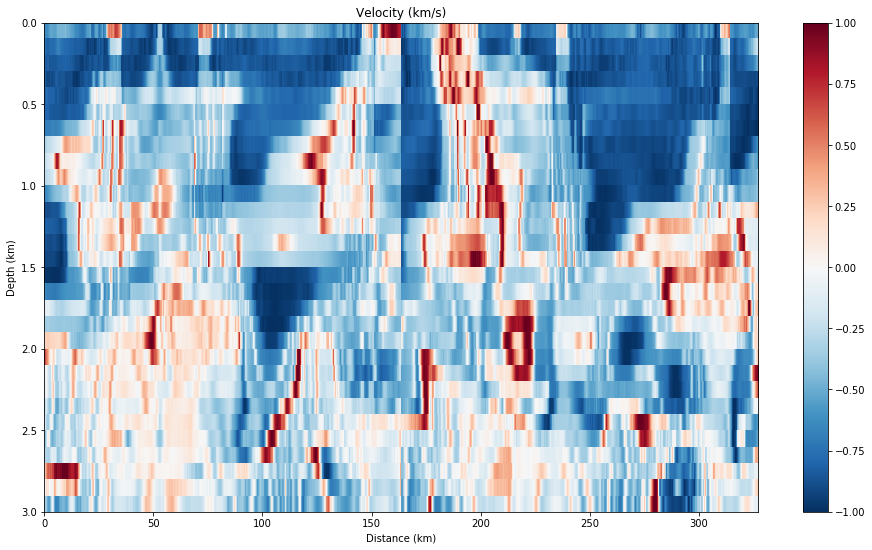

In [13]:
# expand to multiple CMPs as channels in input
def make_multi_CMP_inputs(X_data, T_data, nCMP):
    # first we prepare array for X_data_multi_CMP
    X_data_multi_CMP = np.zeros((X_data.shape[0]-nCMP+1,
                                X_data.shape[1],
                                X_data.shape[2],
                                nCMP))
    for i in range(nCMP-1):
        print(i)
        print(np.shape(X_data_multi_CMP))
        print(np.shape(X_data))
        print(nCMP)
        print(-nCMP+i+1)
        X_data_multi_CMP[:,:,:,i] = X_data[i:-nCMP+i+1,:,:,0]
        
    X_data_multi_CMP[:,:,:,nCMP-1] = X_data[nCMP-1:,:,:,0]
    
    if nCMP==1 :
        T_data_multi_CMP = T_data
    else :
        T_data_multi_CMP = T_data[(nCMP-1)//2 : -(nCMP-1)//2, :]
    
    #print(-(nCMP+1)//2) print(np.shape(X_data_multi_CMP)) print(np.shape(T_data_multi_CMP))
    
    assert (X_data_multi_CMP.shape[0] == T_data_multi_CMP.shape[0])
    
    return X_data_multi_CMP, T_data_multi_CMP

nCMP = 1

X_scaled, T_scaled = make_multi_CMP_inputs(X_scaled, T_scaled, nCMP)

nCMP = 11

X_scaled_multi, T_scaled_multi = make_multi_CMP_inputs(X_scaled, T_scaled, nCMP)


plt_nb_T(1e3*T_scaled, dz=jlogz*dx, fname="../latex/Fig/T_scaled")


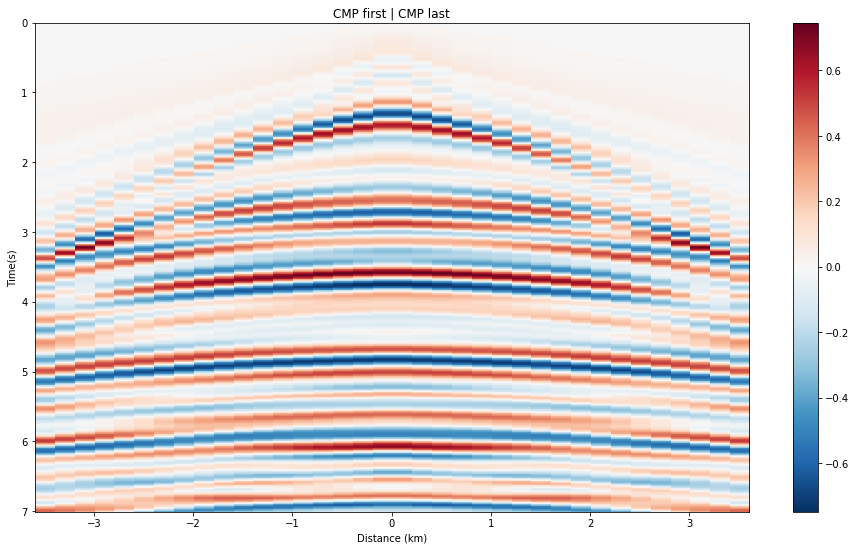

(1, 30)


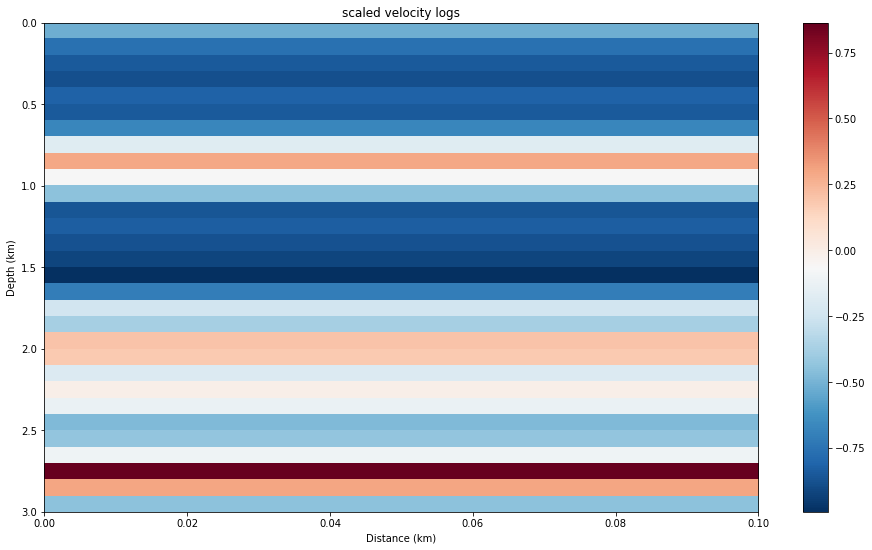

In [14]:
# show single training sample
sample_reveal = 100
plt_nb_T(1e3*np.concatenate((np.squeeze(X_scaled[sample_reveal,:,:,-1]), np.flipud(np.squeeze(X_scaled[sample_reveal,:,:,0]))), axis=0),
        title="CMP first | CMP last", dx=200, dz=1e3*dt*jdt, 
        origin_in_middle=True, ylabel="Time(s)", fname="../latex/Fig/X_scaled")
print(np.shape(1e3*T_scaled[sample_reveal-(nCMP+1)//2:sample_reveal+(nCMP-1)//2:nCMP]))

plt_nb_T(1e3*T_scaled[sample_reveal-(nCMP+1)//2:sample_reveal+(nCMP-1)//2:nCMP,:], 
         dx=100, dz=dx*jlogz, 
         title="scaled velocity logs")

   # CNN construction single CMP -> log under the CMP

In [15]:
# 
from keras.layers import Conv2D, Dense
# pogostics
from keras.layers import Flatten, MaxPool2D, AveragePooling2D, Reshape, BatchNormalization, Dropout
def create_model(inp_shape, out_shape):
    model = keras.models.Sequential()
    activation = 'relu'
    activation_dense = activation
    padding = 'same'
    model.add(Conv2D(filters=4, kernel_size=(5, 5), activation=activation, padding=padding, input_shape=inp_shape))
    model.add(MaxPool2D([1,2]))  
      
    model.add(Conv2D(filters=64, kernel_size=(7, 7), activation=activation, padding=padding))
    model.add(MaxPool2D([1,2]))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation=activation, padding=padding))
    model.add(MaxPool2D([1,2]))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation=activation, padding=padding))
    model.add(MaxPool2D([1,2]))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation=activation, padding=padding))
    model.add(MaxPool2D([1,2]))
    model.add(Conv2D(filters=1, kernel_size=(5, 5), activation=activation, padding=padding))
    model.add(Flatten())
    model.add(Dense(2*out_shape[0], activation=activation_dense))
    model.add(Dropout(0.1))
    model.add(Dense(out_shape[0], activation=activation_dense))
    model.add(Dense(out_shape[0], activation='linear'))
    model.add(Reshape(out_shape))

    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 701, 4)        104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 350, 4)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 350, 64)       12608     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 175, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 175, 32)       51232     
_________________________________________________________________
max_pooling2d_3 (MaxP

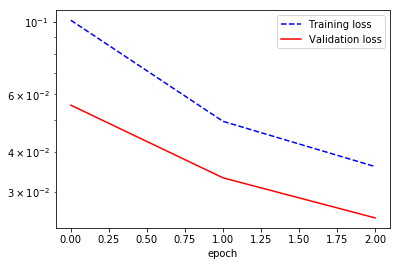

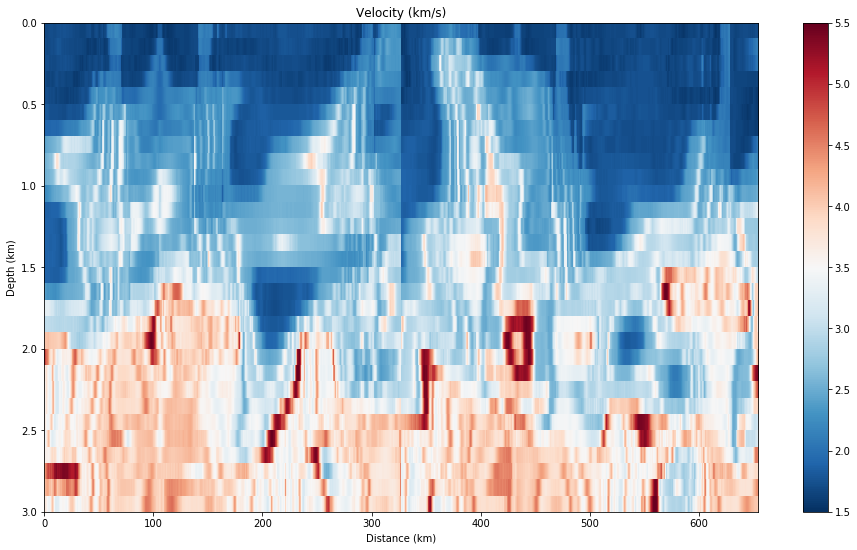

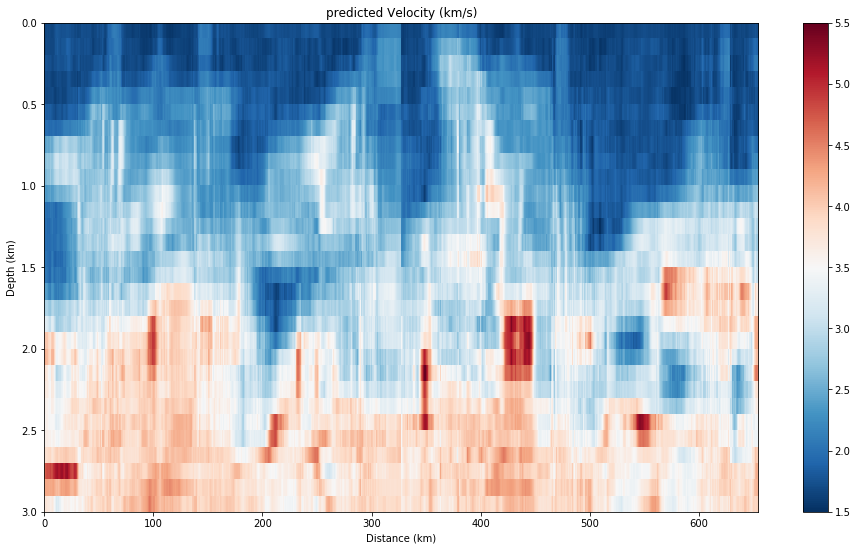

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 18, 701, 4)        1104      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 350, 4)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 350, 64)       12608     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 175, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 175, 32)       51232     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 87, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 87, 32)        25632     
__________

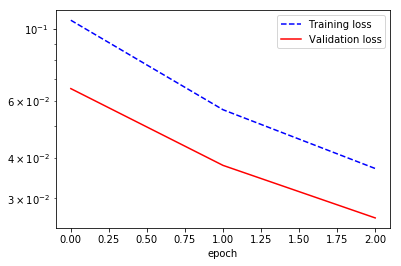

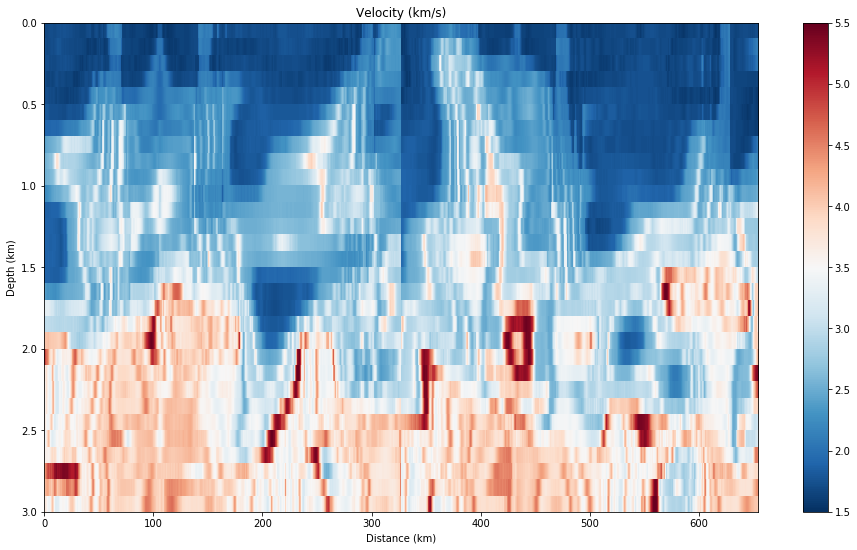

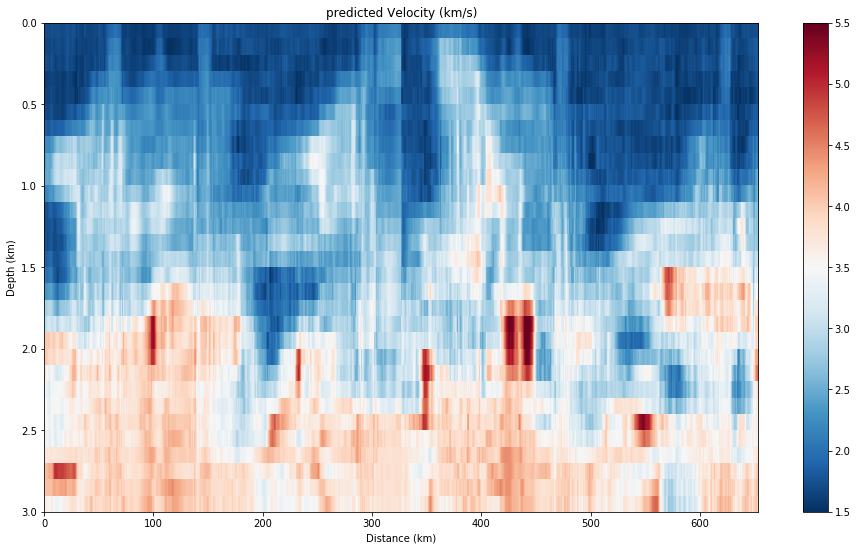

In [16]:
# Init callbacks
def train_model(prefix="single", X_scaled=X_scaled, T_scaled=T_scaled):
    net = create_model(np.shape(X_scaled)[1:], np.shape(T_scaled)[1:])
    net.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint("trained_net",
                                       monitor='val_loss',
                                       save_best_only=True,
                                       period=2)
    # tensorboard = TensorBoard(log_dir=path_to_out_logs, histogram_freq=15, batch_size=batch_size, write_images=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=7, min_lr=0.000001, verbose=1)

    # random validation samples
    from sklearn.model_selection import train_test_split

    # Split the data
    X_train, X_valid, T_train, T_valid = train_test_split(X_scaled, T_scaled, test_size=0.2, shuffle=True)

    # TRAINING
    history = net.fit(X_train, T_train,
                      validation_split=0.2,
                      validation_data=(X_valid, T_valid),
                      epochs=3,
                      batch_size=16,
                      verbose=2,
                      shuffle=True,
                      callbacks=[
                          model_checkpoint,
                          reduce_lr,
                          early_stopping])

    print("Optimization Finished!")
    
    plt.semilogy(history.history['loss'],'b--', label='Training loss')
    plt.semilogy(history.history['val_loss'],'r', label='Validation loss')
    plt.xlabel("epoch")
    plt.legend()
    plt.savefig(f"../latex/Fig/{prefix}_loss", bbox_inches='tight')
    plt.show()
    
    # check the training set
    T_pred = net.predict(X_scaled)
    plt_nb_T(T_data, dx=100, dz=jlogz*dx, 
             fname=f"../latex/Fig/{prefix}_trueTraining", 
             vmin=1.5, vmax=5.5)
    plt_nb_T(T_scaler.inverse_transform(T_pred), dx=100, dz=jlogz*dx,
             fname=f"../latex/Fig/{prefix}_predictedTraining",
             title="predicted Velocity (km/s)", vmin=1.5, vmax=5.5)
    
    return net

singleCMP_net = train_model(prefix="singleCMP", X_scaled=X_scaled, T_scaled=T_scaled)

multiCMP_net = train_model(prefix="multiCMP", X_scaled=X_scaled_multi, T_scaled=T_scaled_multi)

In [17]:
print(type(singleCMP_net))

<class 'keras.engine.sequential.Sequential'>


# We trained the neural net, it fits the training and validation data... 

## How well does it fit?

## Does it fit stretched marmousi itself?

## Could we learn more from models like this?

## Does it work on something different?

## When does it break?!

# Testing

In [18]:
# test for a given model
def test_on_model(folder="marmvel1D",
                  net=singleCMP_net,
                  prefix="singleCMP",
                  model_filename=None, 
                  distort_flag=False,
                  stretch_X=None,
                  jgx=jgx, sxbeg=sxbeg, gxbeg=gxbeg):
    
    if model_filename==None:
        model_filename=f"{folder}.hh"
    
    # expand model
    file_rescaled="vel_test.rsf"
    print(file_rescaled)
    vel_test = generate_model(model_input=model_filename, 
                              file_rescaled=file_rescaled, 
                              stretch_X=stretch_X,
                              distort_flag=distort_flag)
    plt_nb_T(vel_test)
    
    cmd(f"mkdir {folder}")
    cmd(f"cp {file_rescaled} {folder}/{file_rescaled}")
    
    N = np.shape(vel_test)
    
    # check stability
    print(f"you chose dt = {dt}, dt < {dx/np.max(vel):.4f} should be chosen for stability \n")
    # force stability
    assert dt < dx/np.max(vel)
    
    # calculate number of sources and receivers
    ns = (N[0] - 2*sxbeg)//jgx 
    ng = 2*(sxbeg-gxbeg)//jgx + 1
    
    # model data
    generate_rsf_data(model_name=f"{folder}/vel_test.rsf", 
                  shots_out=f"{folder}/shots_cmp_test.rsf", 
                  logs_out=f"{folder}/logs_test.rsf", 
                  ns=ns, ng=ng)
    
    # read data
    X_data_test, T_data_test = read_rsf_to_np(shots_rsf=f"{folder}/shots_cmp_test.rsf", 
                                              logs_rsf=f"{folder}/logs_test.rsf")
    
    # X_scaled
    X_scaled = scale_X_data(X_data_test)
    
    nCMP = int(net.input.shape[3])
    X_scaled, T_data_test = make_multi_CMP_inputs(X_scaled, T_data_test, nCMP)

    
    # predict
    T_pred = net.predict(X_scaled)
    
    # show single testing sample
    sample_reveal = 50
    plt_nb_T(1e3*np.concatenate((np.squeeze(X_scaled[sample_reveal,:,:,-1]), np.flipud(np.squeeze(X_scaled[sample_reveal,:,:,0]))), axis=0),
        title="CMP first | CMP last", dx=200, dz=1e3*dt*jdt, 
        origin_in_middle=True, ylabel="Time(s)", fname="../latex/Fig/X_scaled")
    print(np.shape(1e3*T_scaled[sample_reveal-(nCMP+1)//2:sample_reveal+(nCMP-1)//2:nCMP]))

    plt_nb_T(1e3*T_scaled[sample_reveal-(nCMP+1)//2:sample_reveal+(nCMP-1)//2:nCMP,:], 
         dx=100, dz=dx*jlogz, 
         title="scaled velocity logs")
    
    # plot
    plt_nb_T(np.maximum(1.5e3*np.ones_like(T_pred), 
                        np.minimum(5.5e3*np.ones_like(T_pred), T_scaler.inverse_transform(T_pred))), 
             dx=jgx*dx, dz=jlogz*dx, 
             fname=f"../latex/Fig/test{prefix}_{folder}_inverted",
             title="inverted")
    plt_nb_T(T_data_test, 
             dx=jgx*dx, dz=jlogz*dx,
             fname=f"../latex/Fig/test{prefix}_{folder}_true",
             title="true")

<class 'keras.engine.sequential.Sequential'>
vel_test.rsf
(251, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to vel_test.rsf


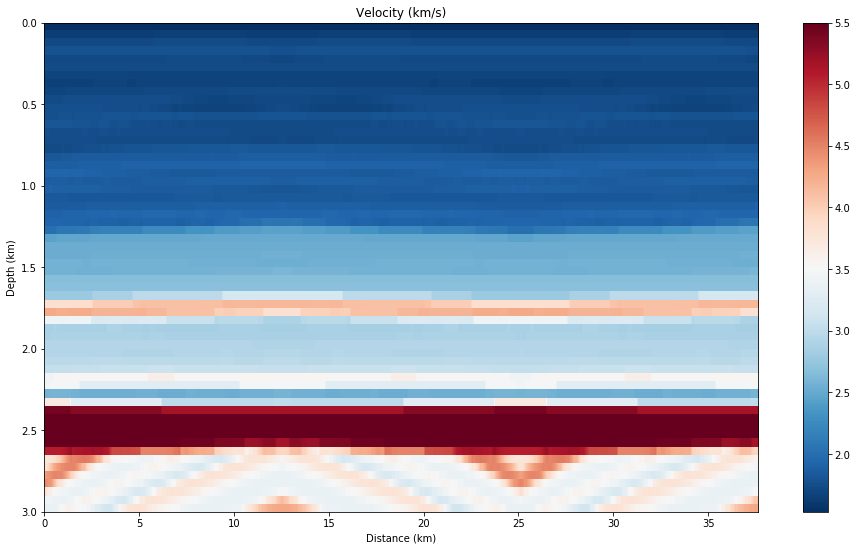

mkdir: cannot create directory ‘marmvel1D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 276
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.338034 (s)
sfgenshots: shot 11 finished: 0.031365 (s)
sfgenshots: shot 21 finished: 0.031210 (s)
sfgenshots: shot 31 finished: 0.031272 (s)
sfgenshots: shot 41 finished: 0.031146 (s)
sfgenshots: shot 51 finished: 0.031218 (s)
sfgenshots: shot 61 finished: 0.031051 (s)
sfgenshots: shot 71 finished: 0.031097 (s)
sfgenshots: shot 81 finished: 0.031135 (s)
sfgenshots: shot 91 finished: 0.031206 (s)
sfgenshots: shot 101 finished: 0.031152 (s)
sfgenshots: shot 111

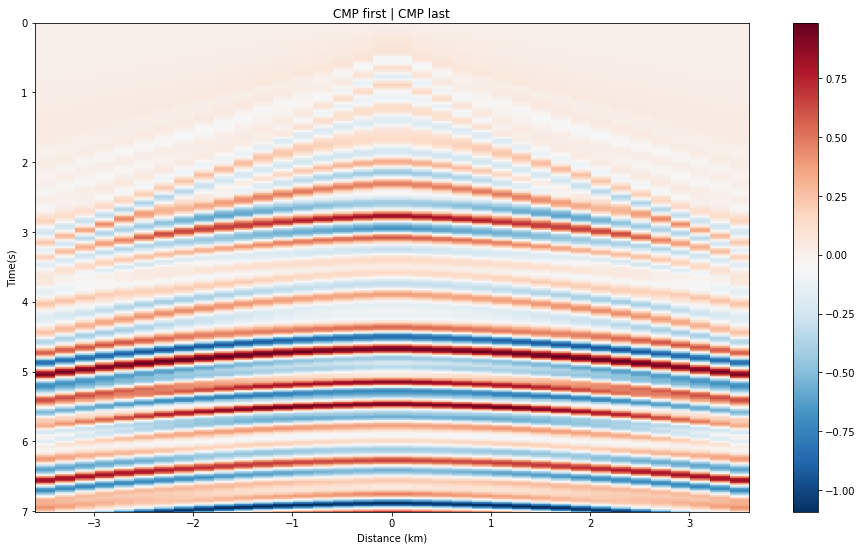

(1, 30)


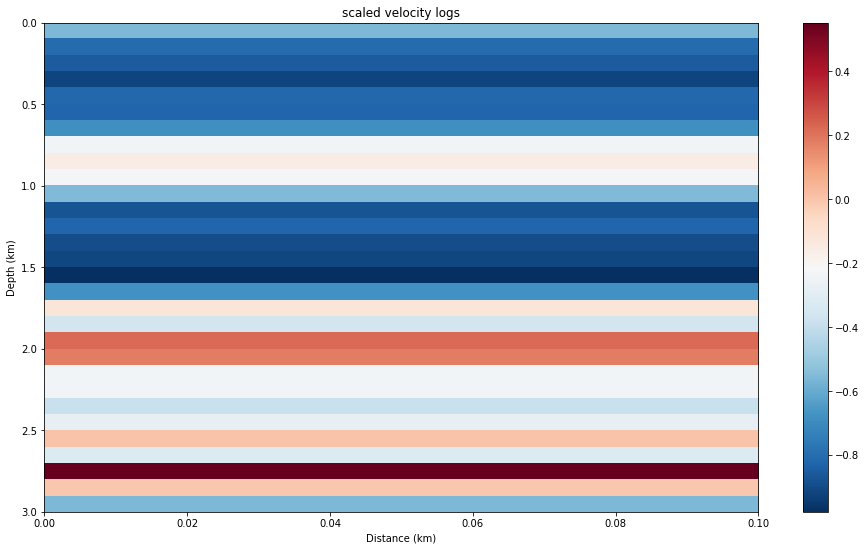

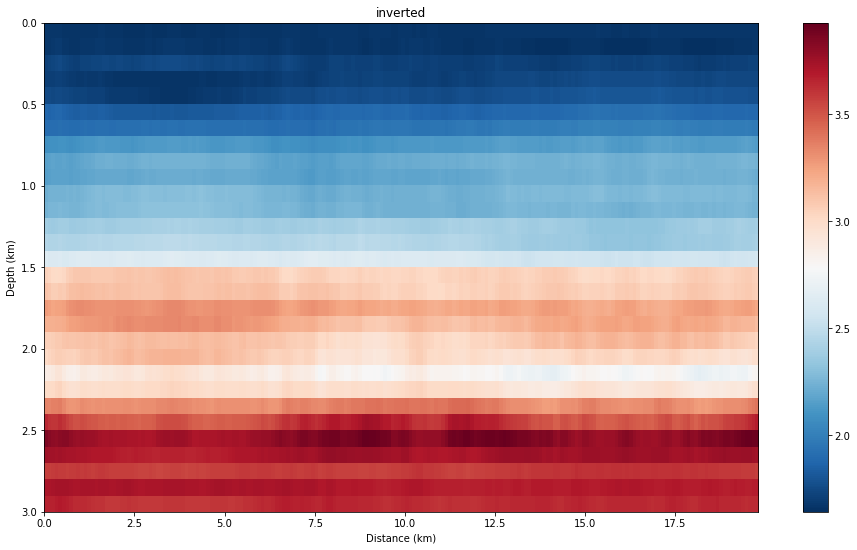

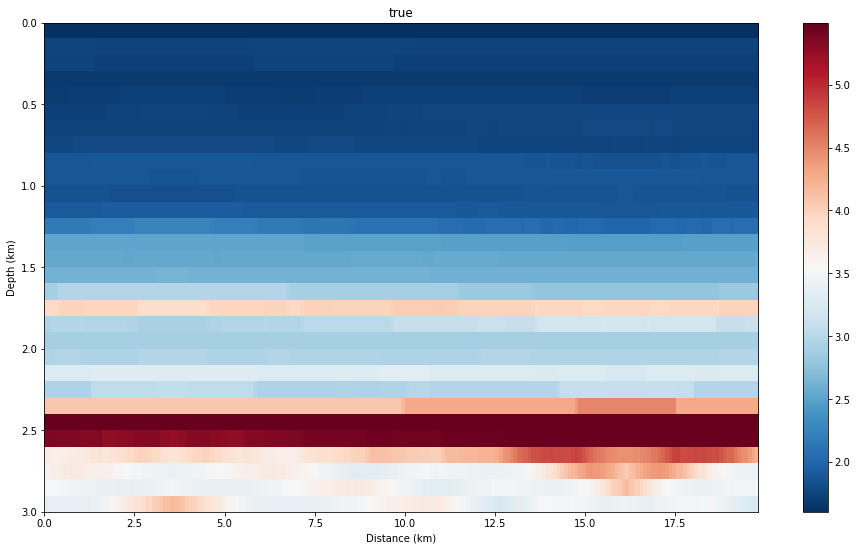


vel_test.rsf
(251, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to vel_test.rsf
(753, 60, 1)


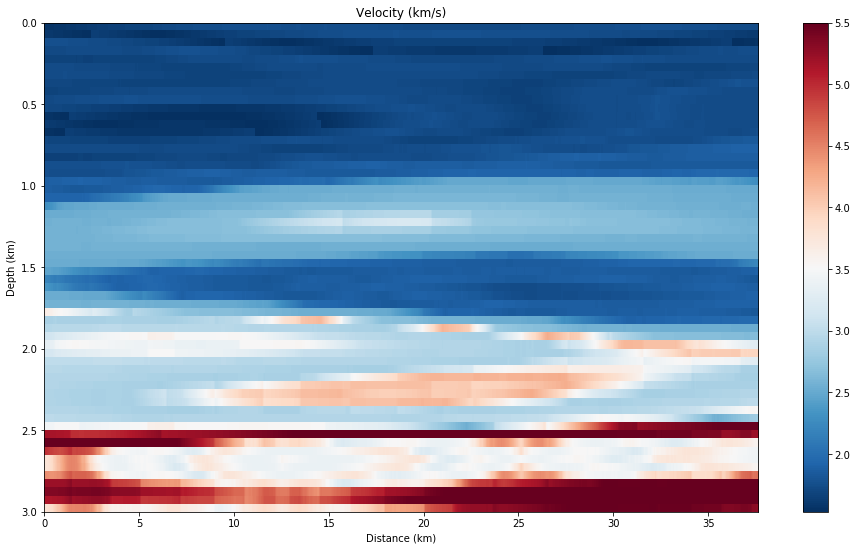

mkdir: cannot create directory ‘marmvel1D_distort’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 276
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.093694 (s)
sfgenshots: shot 11 finished: 0.031110 (s)
sfgenshots: shot 21 finished: 0.031009 (s)
sfgenshots: shot 31 finished: 0.030897 (s)
sfgenshots: shot 41 finished: 0.030892 (s)
sfgenshots: shot 51 finished: 0.031129 (s)
sfgenshots: shot 61 finished: 0.031127 (s)
sfgenshots: shot 71 finished: 0.031035 (s)
sfgenshots: shot 81 finished: 0.030998 (s)
sfgenshots: shot 91 finished: 0.031091 (s)
sfgenshots: shot 101 finished: 0.031086 (s)
sfgenshots: 

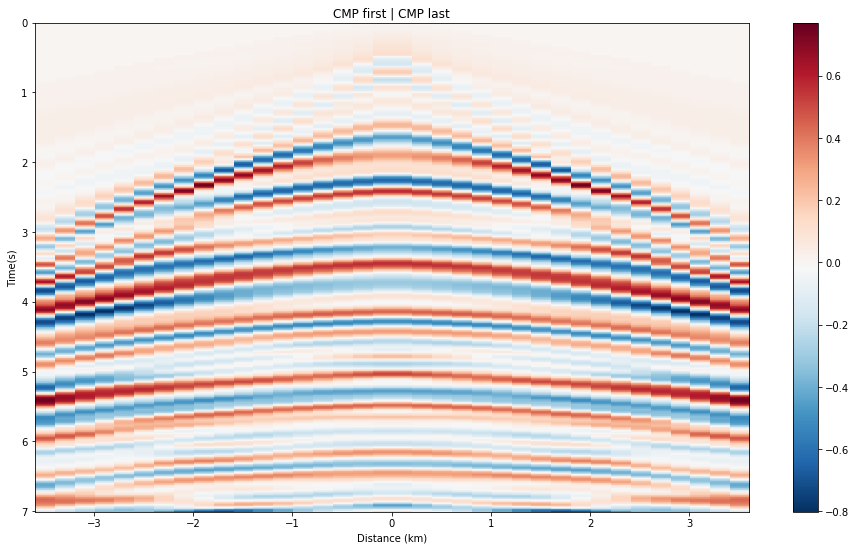

(1, 30)


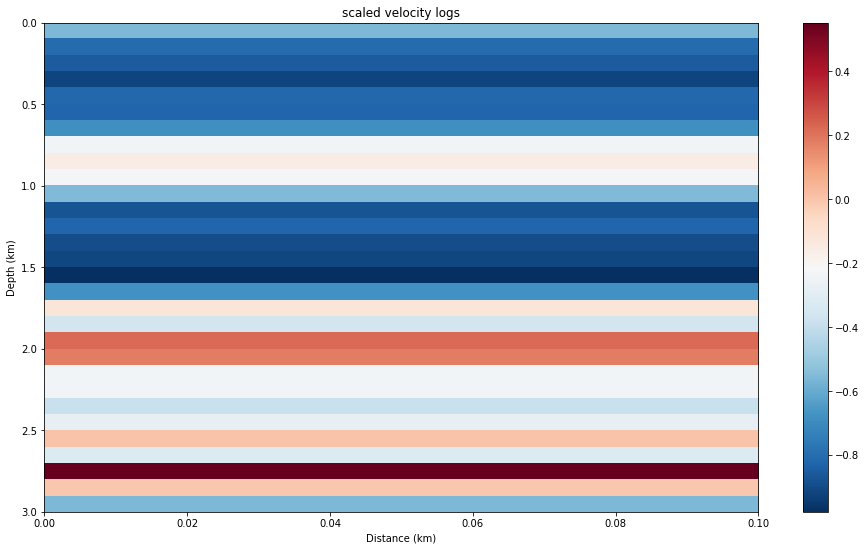

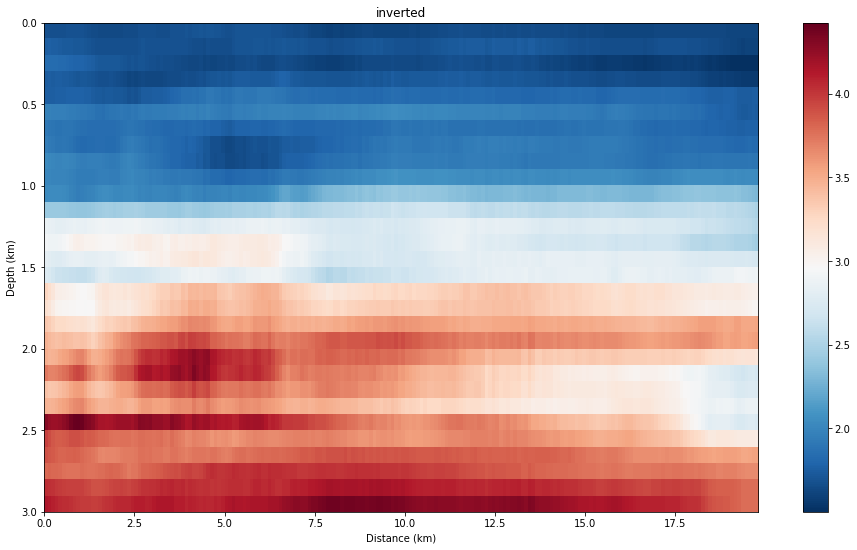

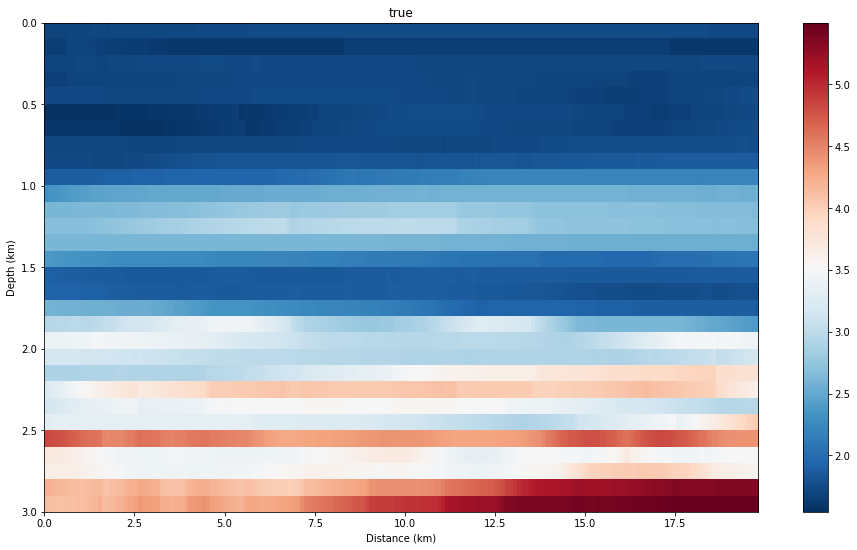

vel_test.rsf
(201, 120)
Model downscaled 2.0 times to 50 meter sampling 

Writing to vel_test.rsf


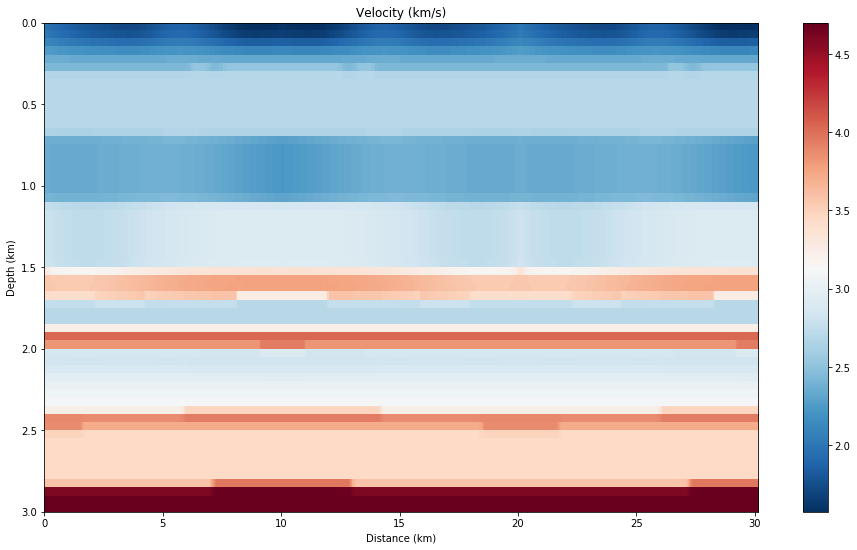

mkdir: cannot create directory ‘overthrust1D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 201
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.092564 (s)
sfgenshots: shot 11 finished: 0.030745 (s)
sfgenshots: shot 21 finished: 0.030679 (s)
sfgenshots: shot 31 finished: 0.030747 (s)
sfgenshots: shot 41 finished: 0.030846 (s)
sfgenshots: shot 51 finished: 0.030623 (s)
sfgenshots: shot 61 finished: 0.030671 (s)
sfgenshots: shot 71 finished: 0.030708 (s)
sfgenshots: shot 81 finished: 0.030631 (s)
sfgenshots: shot 91 finished: 0.030708 (s)
sfgenshots: shot 101 finished: 0.030724 (s)
sfgenshots: shot 

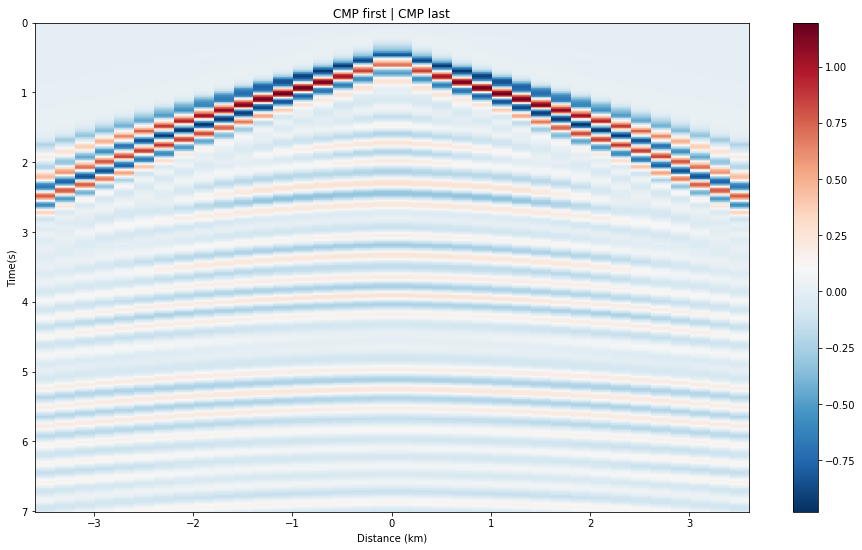

(1, 30)


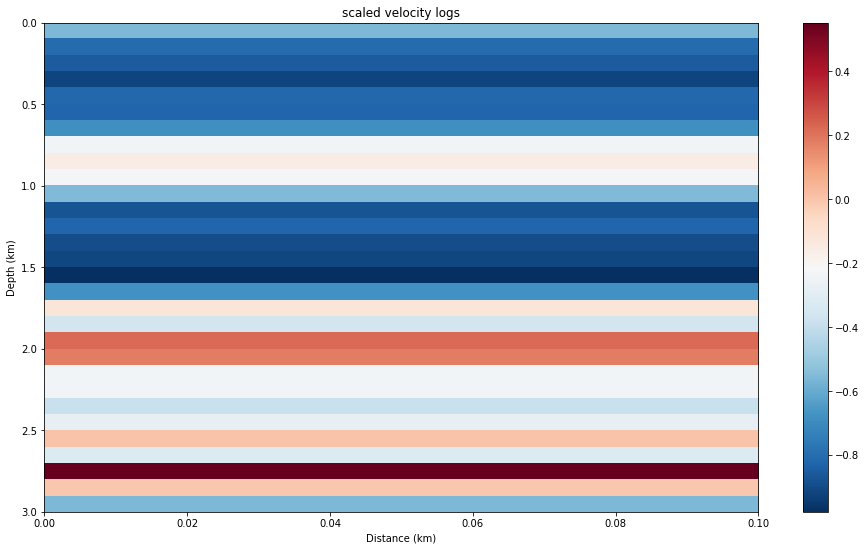

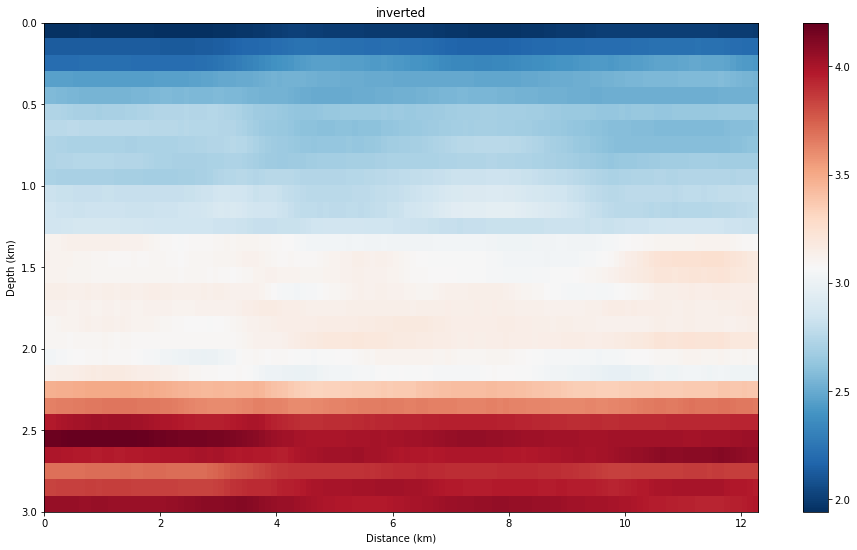

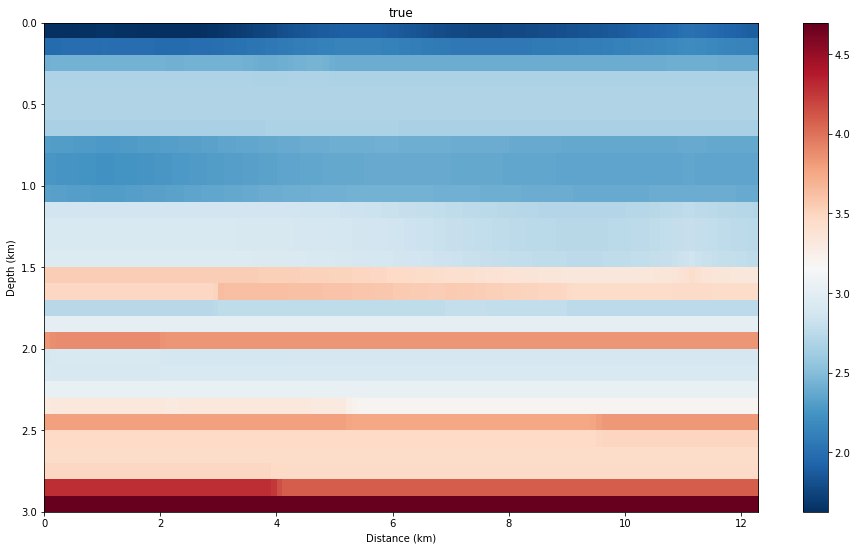


vel_test.rsf
(2301, 751)
Model stretched 3 times to 50 meter sampling 

Writing to vel_test.rsf


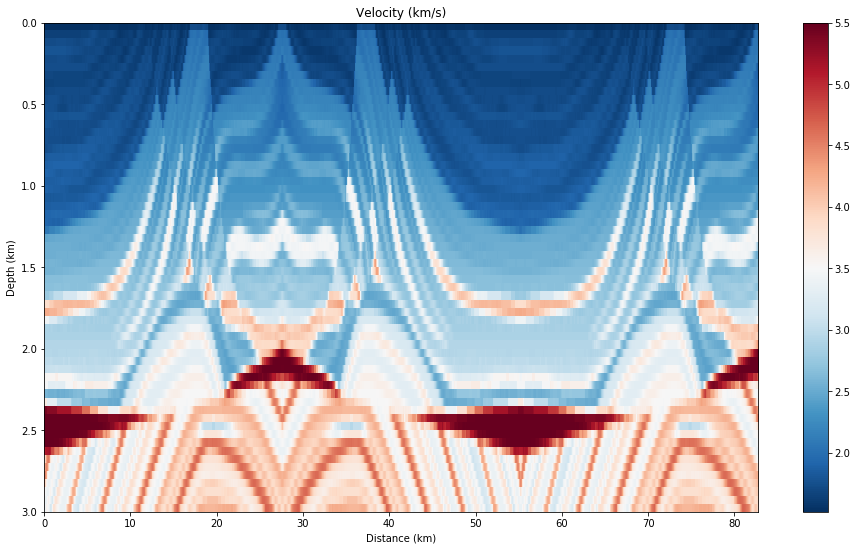

mkdir: cannot create directory ‘marmvel_x3’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 728
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.096889 (s)
sfgenshots: shot 11 finished: 0.046031 (s)
sfgenshots: shot 21 finished: 0.045906 (s)
sfgenshots: shot 31 finished: 0.046167 (s)
sfgenshots: shot 41 finished: 0.045986 (s)
sfgenshots: shot 51 finished: 0.046105 (s)
sfgenshots: shot 61 finished: 0.045916 (s)
sfgenshots: shot 71 finished: 0.046149 (s)
sfgenshots: shot 81 finished: 0.046043 (s)
sfgenshots: shot 91 finished: 0.046229 (s)
sfgenshots: shot 101 finished: 0.045868 (s)
sfgenshots: shot 11

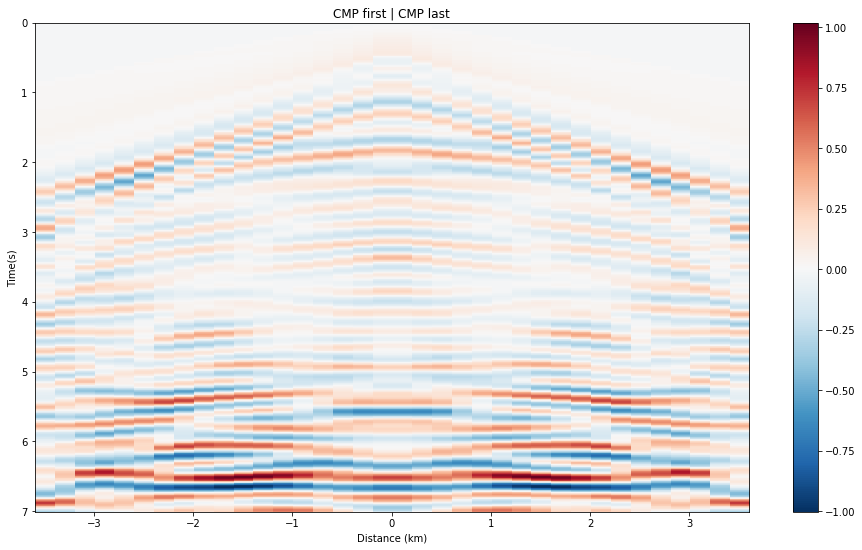

(1, 30)


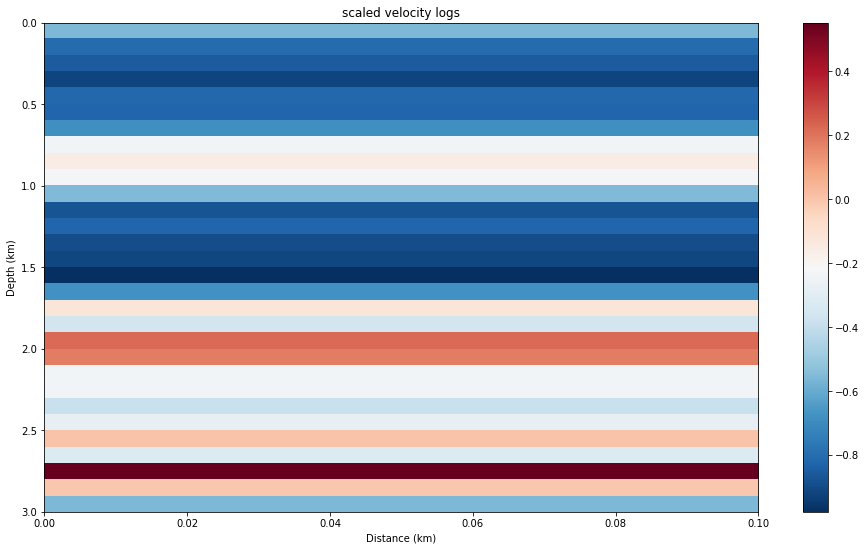

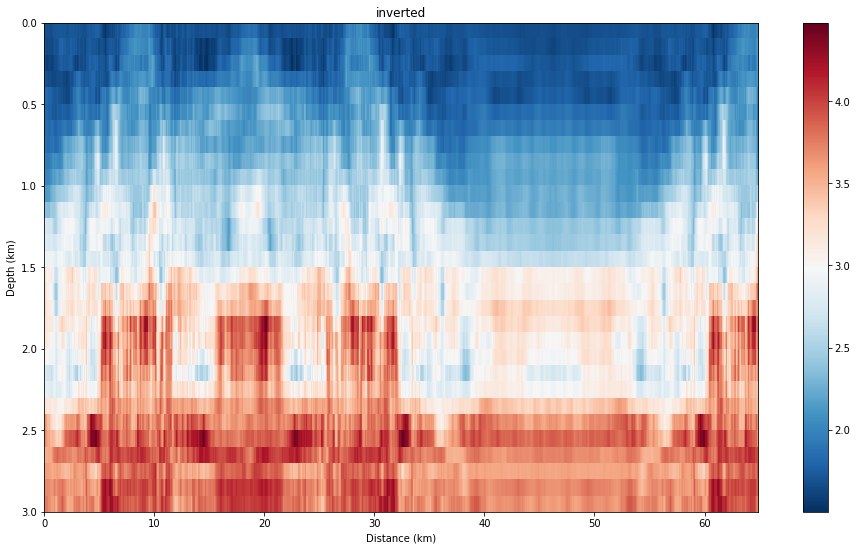

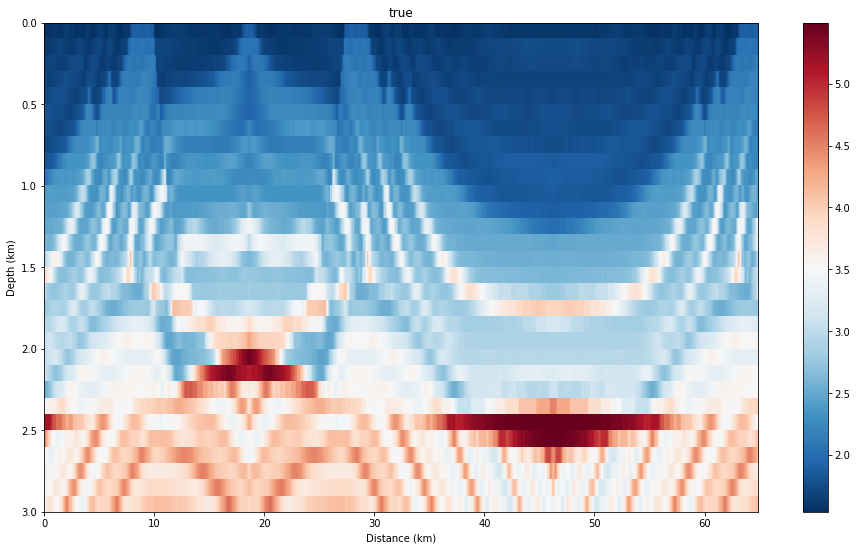

cp: 'marmvel.hh' and 'marmvel.hh' are the same file

vel_test.rsf
(2301, 751)
Model stretched 1 times to 50 meter sampling 

Writing to vel_test.rsf


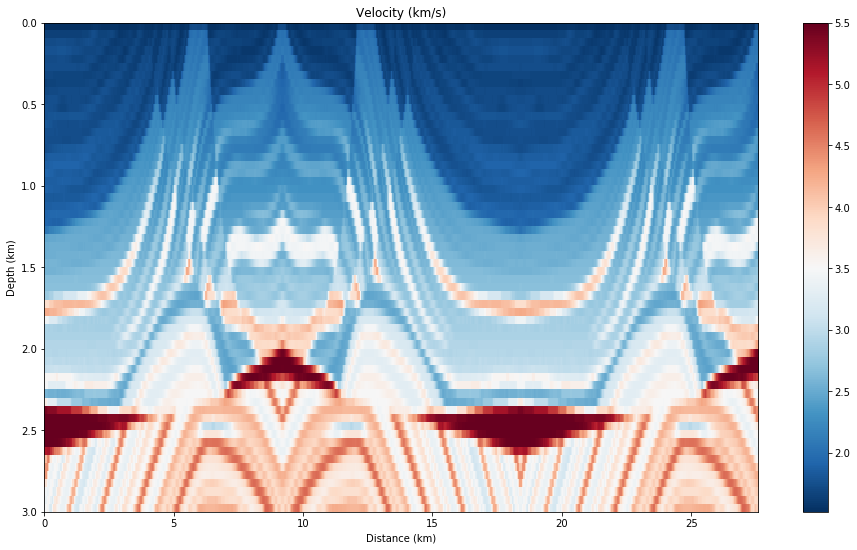

mkdir: cannot create directory ‘marmvel’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 176
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.156986 (s)
sfgenshots: shot 11 finished: 0.045709 (s)
sfgenshots: shot 21 finished: 0.033474 (s)
sfgenshots: shot 31 finished: 0.032990 (s)
sfgenshots: shot 41 finished: 0.032853 (s)
sfgenshots: shot 51 finished: 0.035131 (s)
sfgenshots: shot 61 finished: 0.033063 (s)
sfgenshots: shot 71 finished: 0.033317 (s)
sfgenshots: shot 81 finished: 0.032957 (s)
sfgenshots: shot 91 finished: 0.033056 (s)
sfgenshots: shot 101 finished: 0.032709 (s)
sfgenshots: shot 111 f

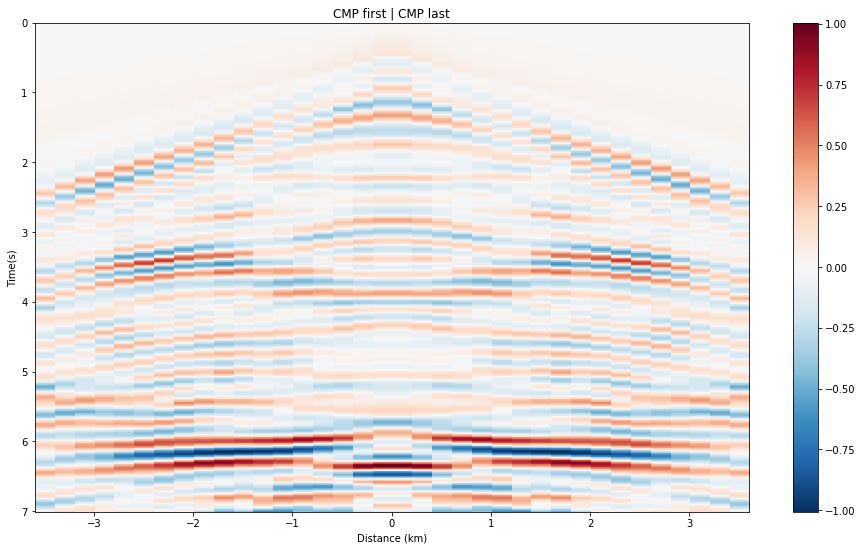

(1, 30)


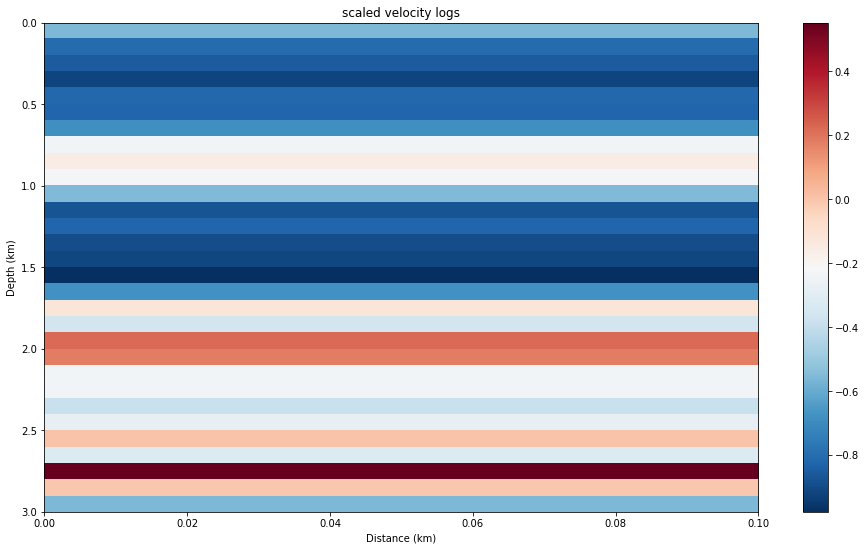

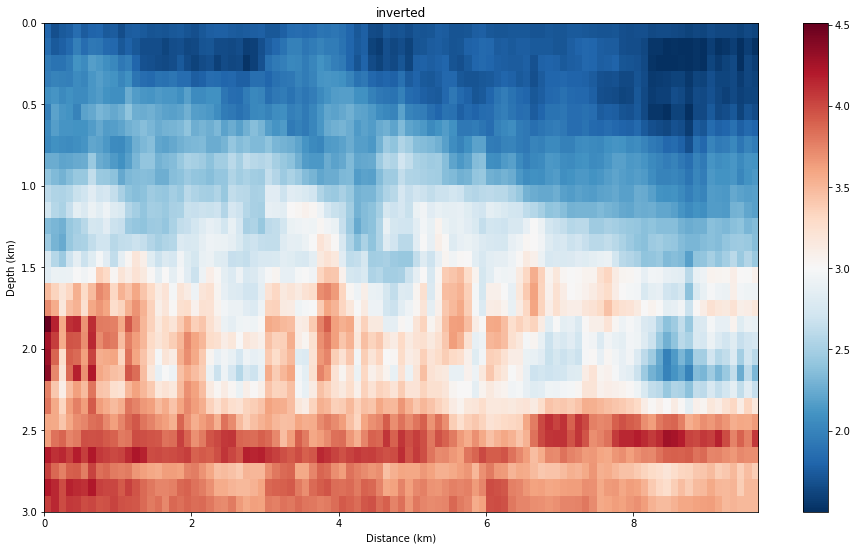

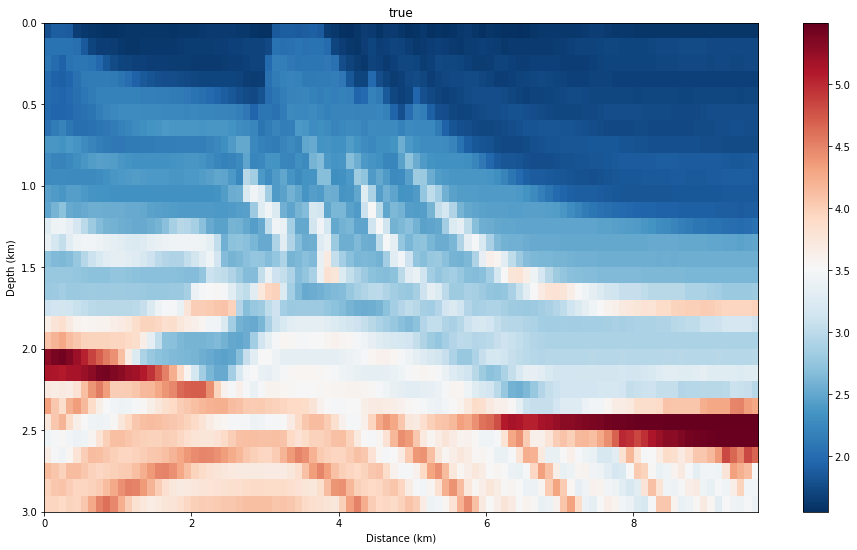

vel_test.rsf
(801, 120)
Model stretched 1 times to 50 meter sampling 

Writing to vel_test.rsf


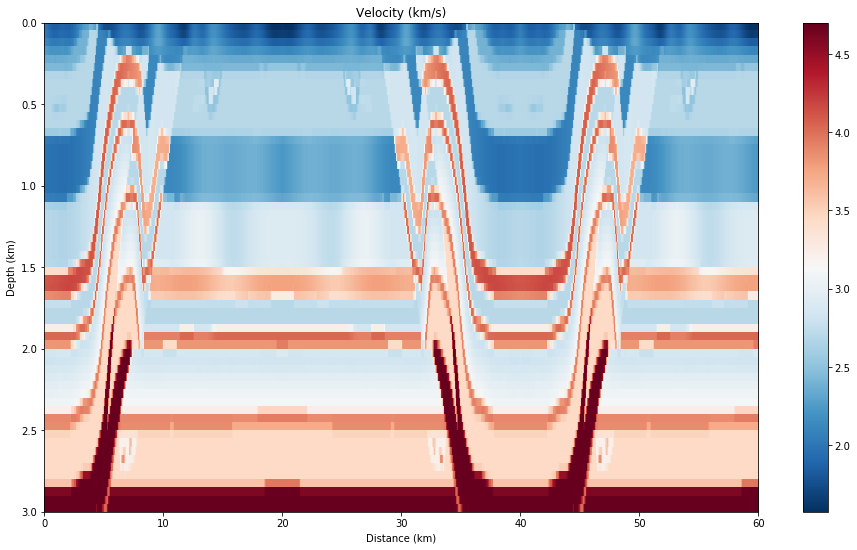

mkdir: cannot create directory ‘overthrust2D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 500
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.089261 (s)
sfgenshots: shot 11 finished: 0.040719 (s)
sfgenshots: shot 21 finished: 0.040983 (s)
sfgenshots: shot 31 finished: 0.040752 (s)
sfgenshots: shot 41 finished: 0.040646 (s)
sfgenshots: shot 51 finished: 0.040719 (s)
sfgenshots: shot 61 finished: 0.040878 (s)
sfgenshots: shot 71 finished: 0.040943 (s)
sfgenshots: shot 81 finished: 0.041016 (s)
sfgenshots: shot 91 finished: 0.041007 (s)
sfgenshots: shot 101 finished: 0.040692 (s)
sfgenshots: shot 

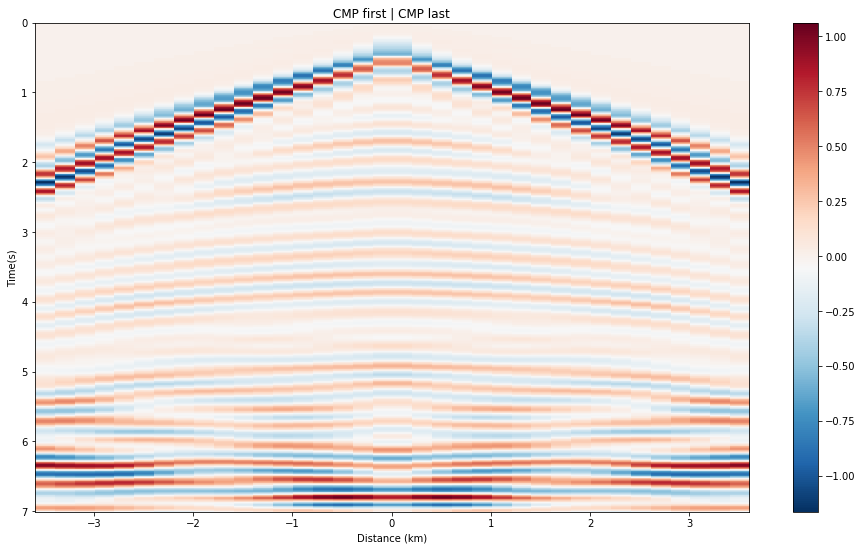

(1, 30)


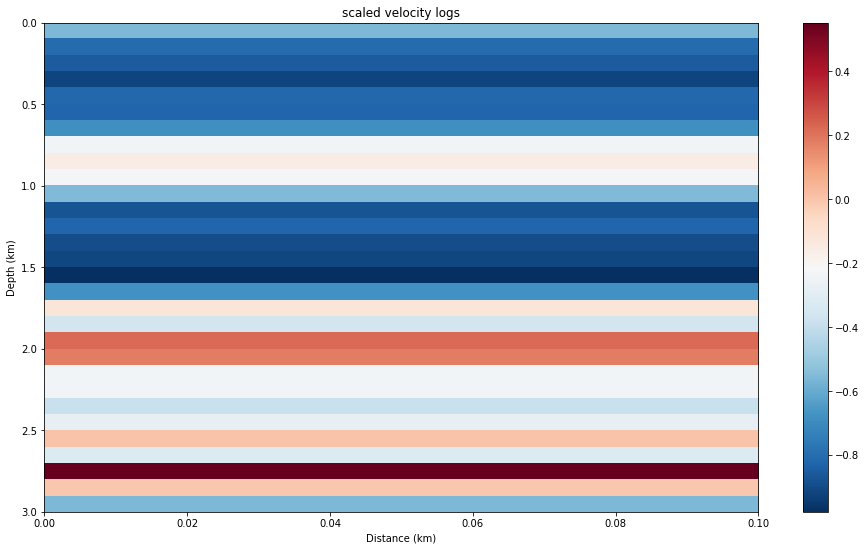

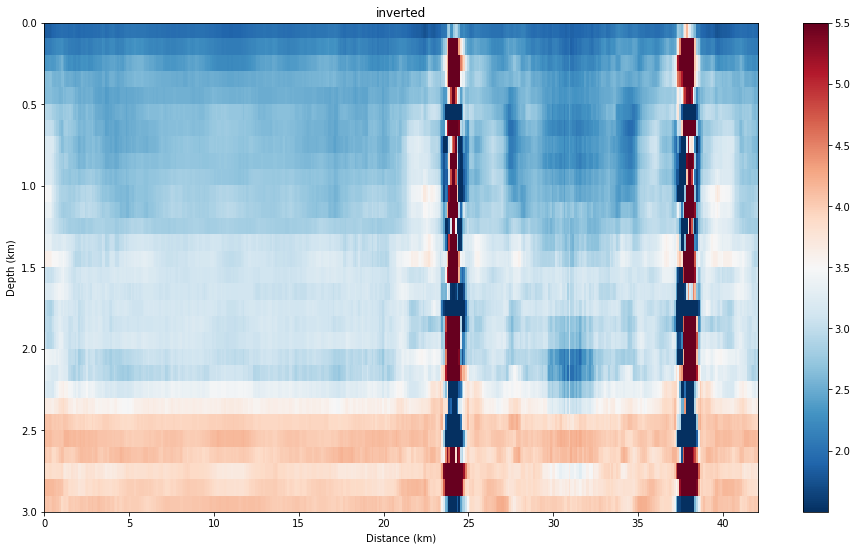

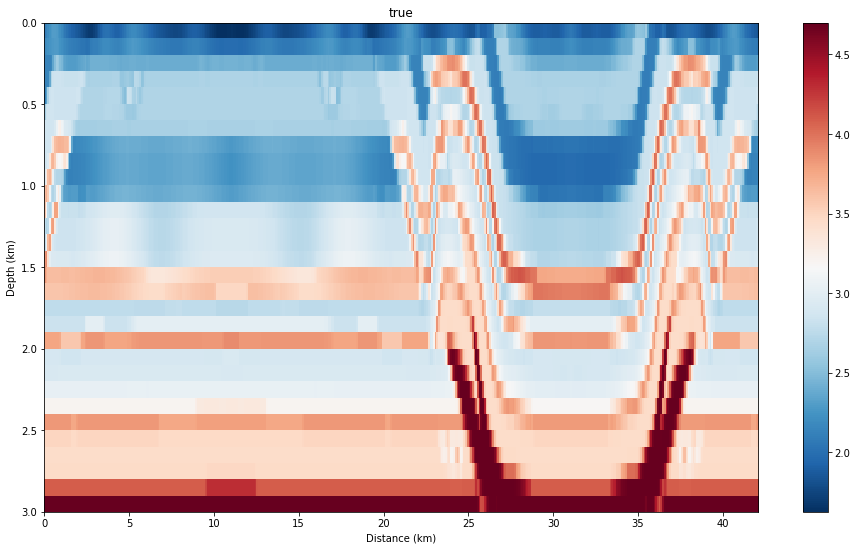

<class 'keras.engine.sequential.Sequential'>
vel_test.rsf
(251, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to vel_test.rsf


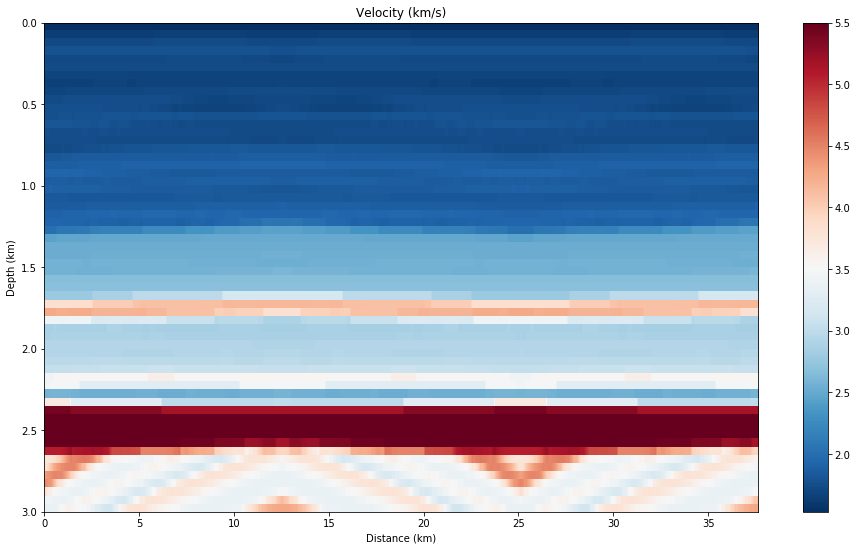

mkdir: cannot create directory ‘marmvel1D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 276
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.125714 (s)
sfgenshots: shot 11 finished: 0.031026 (s)
sfgenshots: shot 21 finished: 0.031054 (s)
sfgenshots: shot 31 finished: 0.031044 (s)
sfgenshots: shot 41 finished: 0.031037 (s)
sfgenshots: shot 51 finished: 0.031024 (s)
sfgenshots: shot 61 finished: 0.030944 (s)
sfgenshots: shot 71 finished: 0.030943 (s)
sfgenshots: shot 81 finished: 0.030790 (s)
sfgenshots: shot 91 finished: 0.030772 (s)
sfgenshots: shot 101 finished: 0.030856 (s)
sfgenshots: shot 111

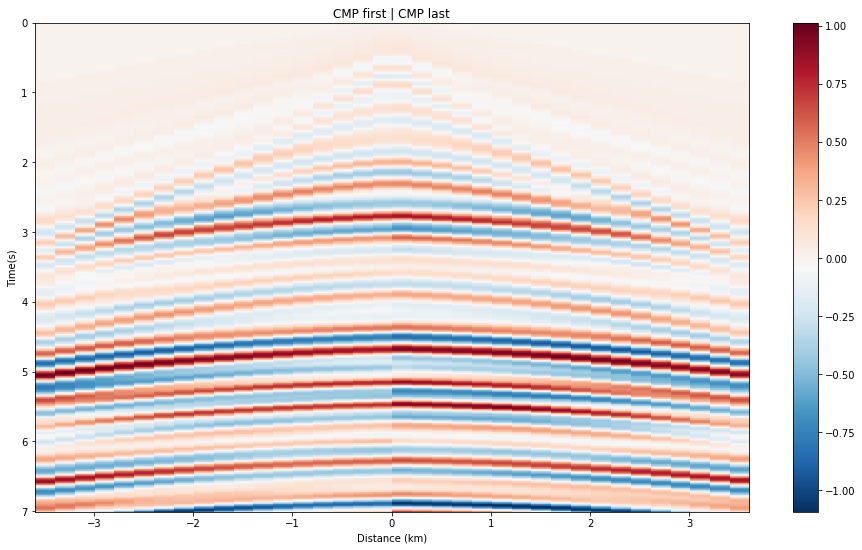

(1, 30)


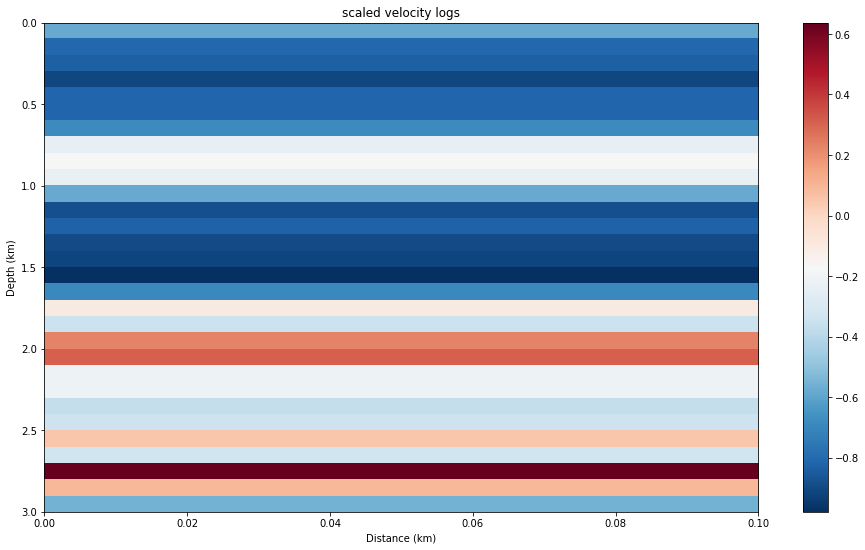

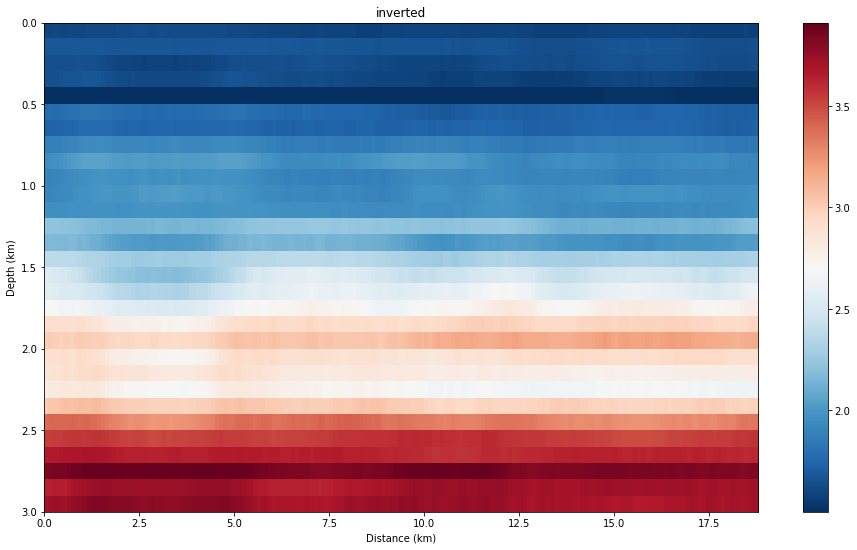

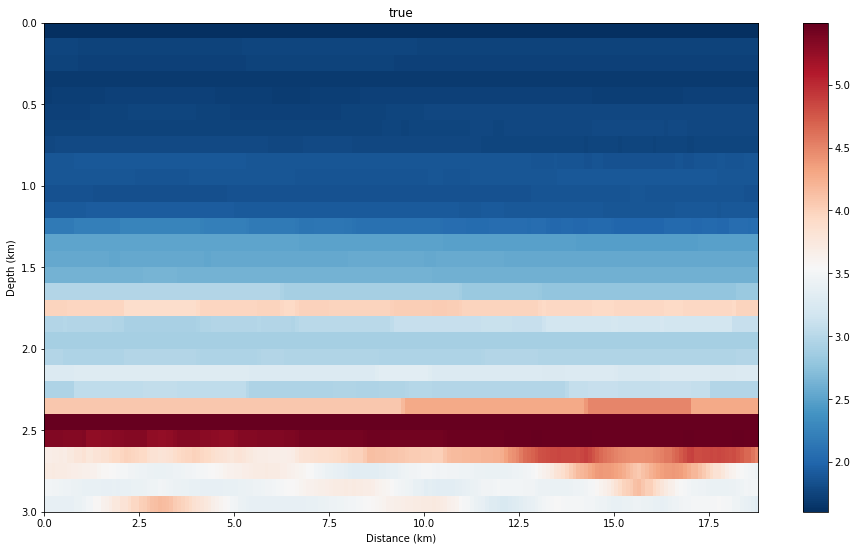


vel_test.rsf
(251, 751)
Model downscaled 12.5 times to 50 meter sampling 

Writing to vel_test.rsf
(753, 60, 1)


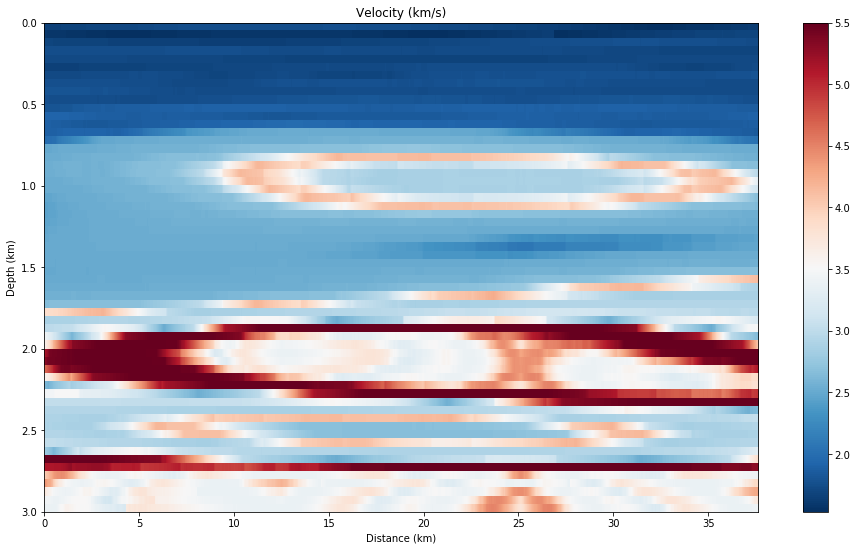

mkdir: cannot create directory ‘marmvel1D_distort’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 276
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.089128 (s)
sfgenshots: shot 11 finished: 0.031292 (s)
sfgenshots: shot 21 finished: 0.031133 (s)
sfgenshots: shot 31 finished: 0.031190 (s)
sfgenshots: shot 41 finished: 0.031103 (s)
sfgenshots: shot 51 finished: 0.031054 (s)
sfgenshots: shot 61 finished: 0.030977 (s)
sfgenshots: shot 71 finished: 0.030941 (s)
sfgenshots: shot 81 finished: 0.030903 (s)
sfgenshots: shot 91 finished: 0.030984 (s)
sfgenshots: shot 101 finished: 0.031157 (s)
sfgenshots: 

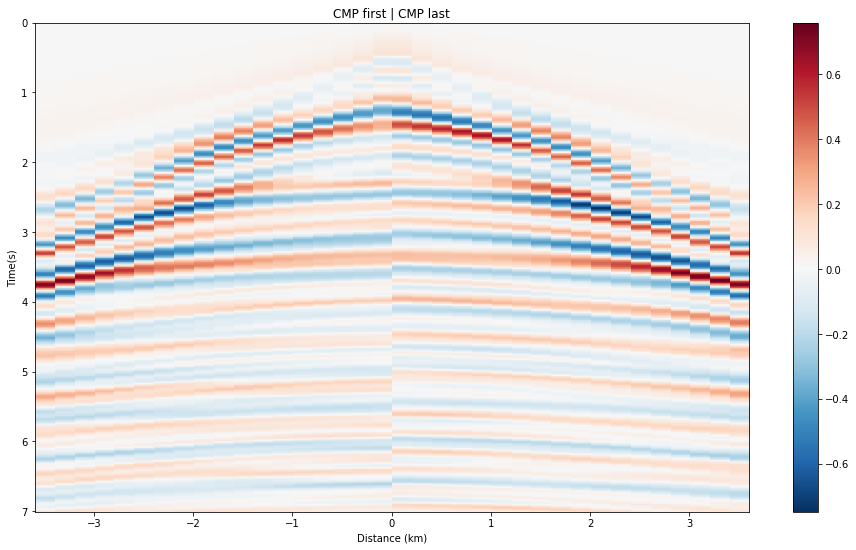

(1, 30)


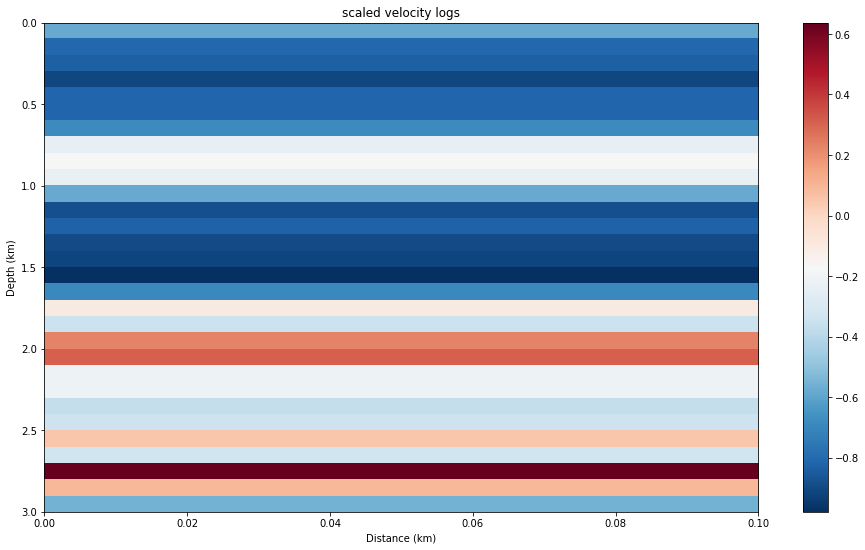

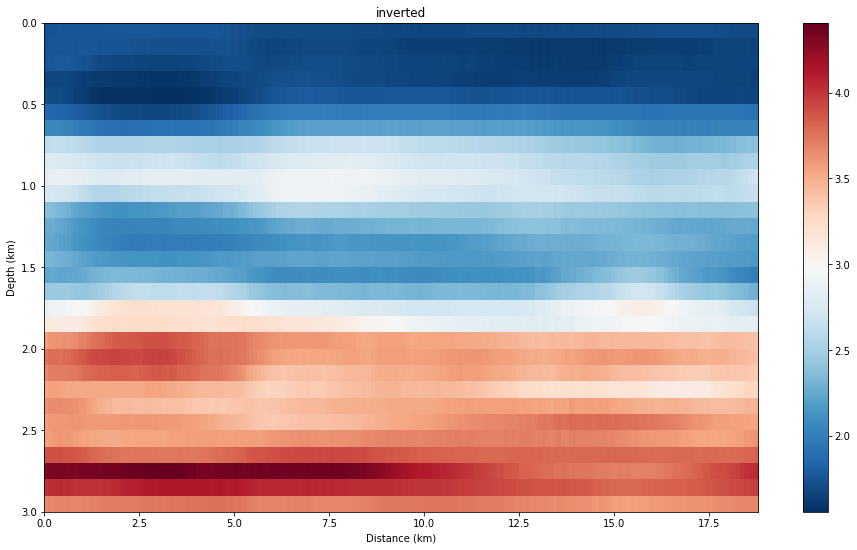

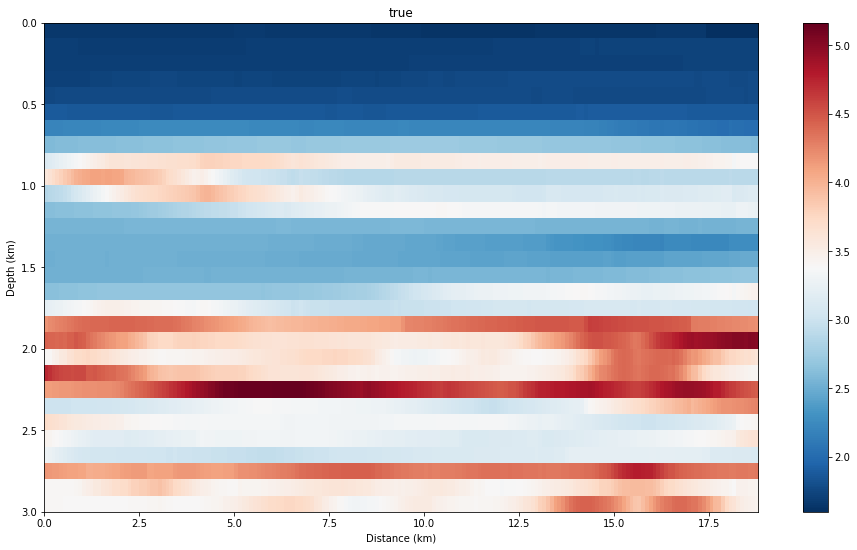

vel_test.rsf
(201, 120)
Model downscaled 2.0 times to 50 meter sampling 

Writing to vel_test.rsf


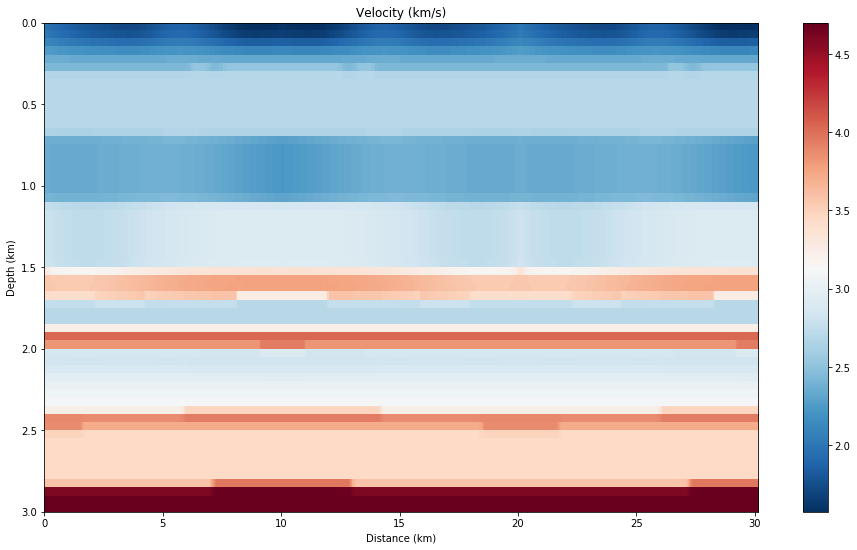

mkdir: cannot create directory ‘overthrust1D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 201
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.088650 (s)
sfgenshots: shot 11 finished: 0.030796 (s)
sfgenshots: shot 21 finished: 0.030847 (s)
sfgenshots: shot 31 finished: 0.030760 (s)
sfgenshots: shot 41 finished: 0.030806 (s)
sfgenshots: shot 51 finished: 0.030798 (s)
sfgenshots: shot 61 finished: 0.030781 (s)
sfgenshots: shot 71 finished: 0.030782 (s)
sfgenshots: shot 81 finished: 0.030835 (s)
sfgenshots: shot 91 finished: 0.030775 (s)
sfgenshots: shot 101 finished: 0.030837 (s)
sfgenshots: shot 

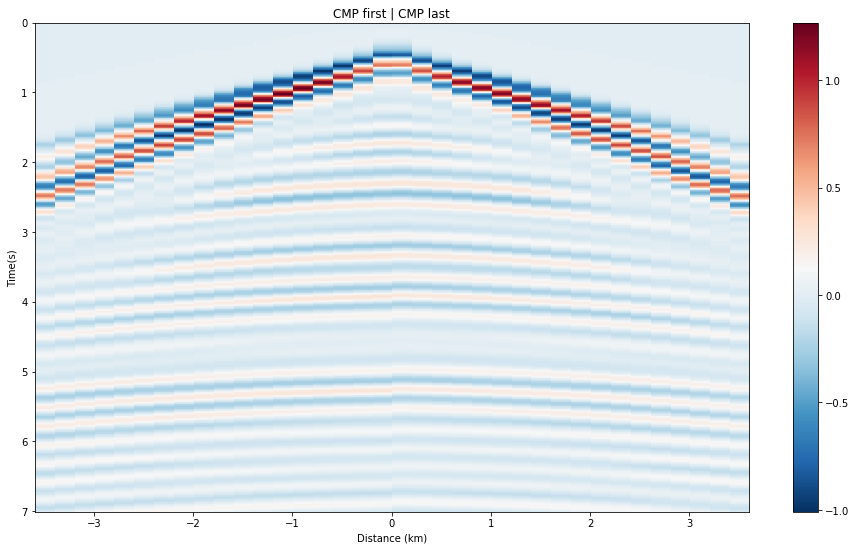

(1, 30)


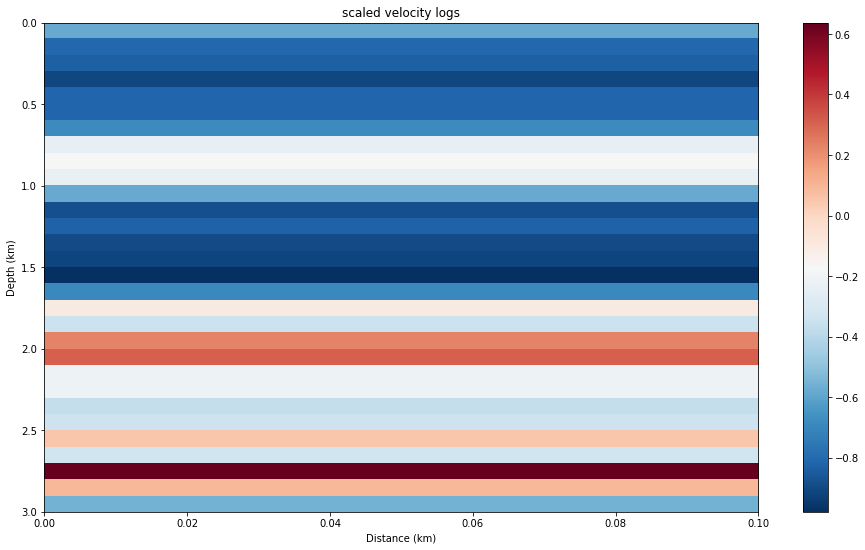

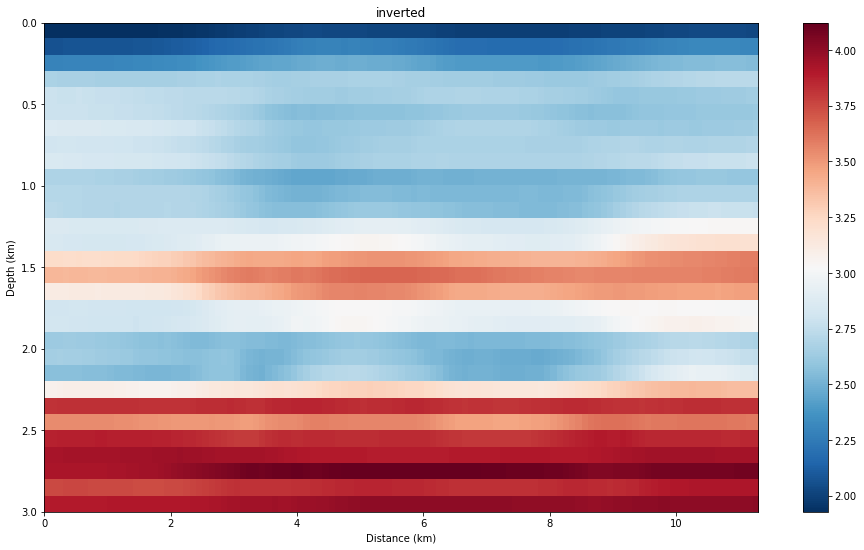

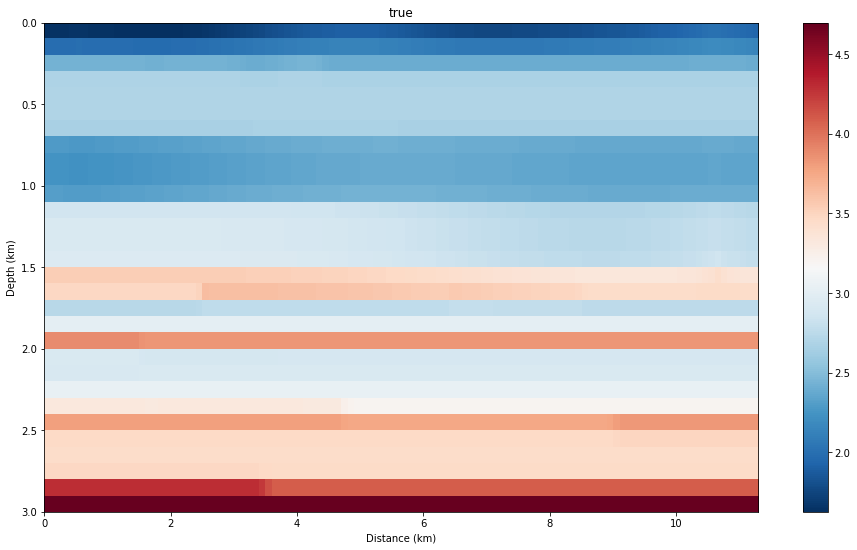


vel_test.rsf
(2301, 751)
Model stretched 3 times to 50 meter sampling 

Writing to vel_test.rsf


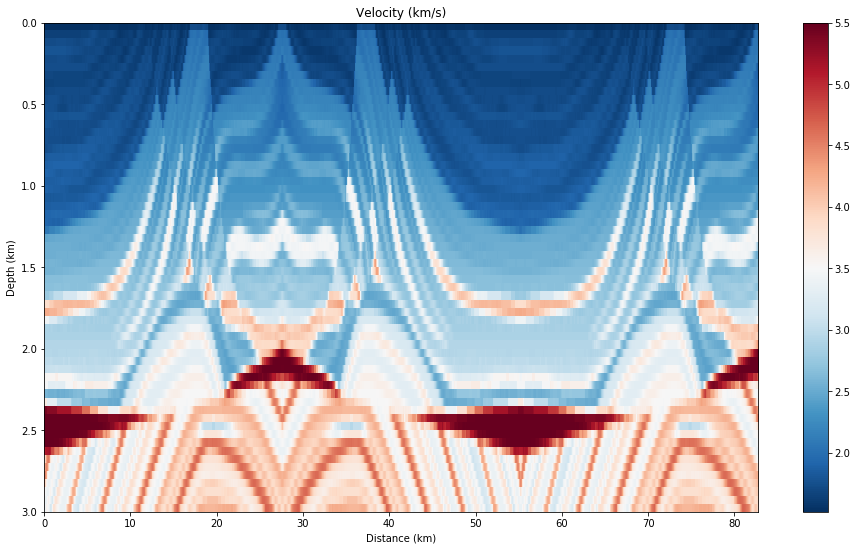

mkdir: cannot create directory ‘marmvel_x3’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 728
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.099858 (s)
sfgenshots: shot 11 finished: 0.046043 (s)
sfgenshots: shot 21 finished: 0.045769 (s)
sfgenshots: shot 31 finished: 0.045914 (s)
sfgenshots: shot 41 finished: 0.045722 (s)
sfgenshots: shot 51 finished: 0.045960 (s)
sfgenshots: shot 61 finished: 0.045682 (s)
sfgenshots: shot 71 finished: 0.045934 (s)
sfgenshots: shot 81 finished: 0.045946 (s)
sfgenshots: shot 91 finished: 0.046042 (s)
sfgenshots: shot 101 finished: 0.045786 (s)
sfgenshots: shot 11

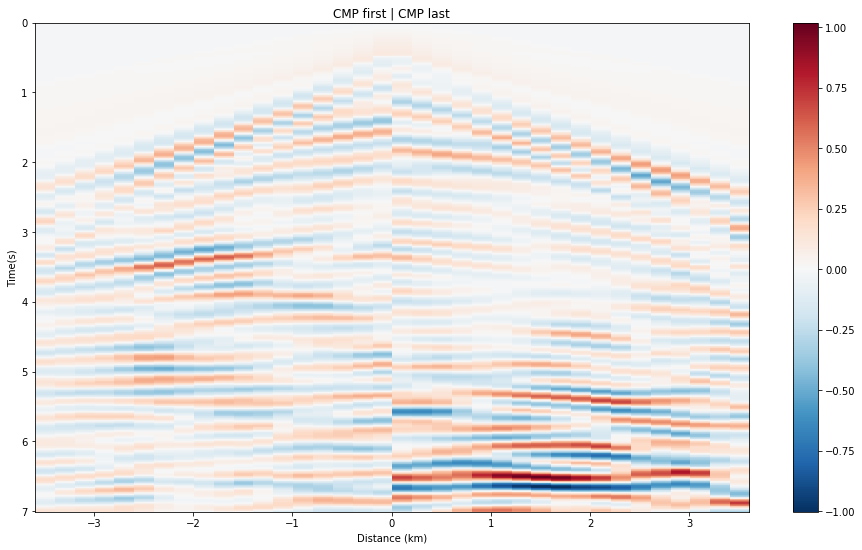

(1, 30)


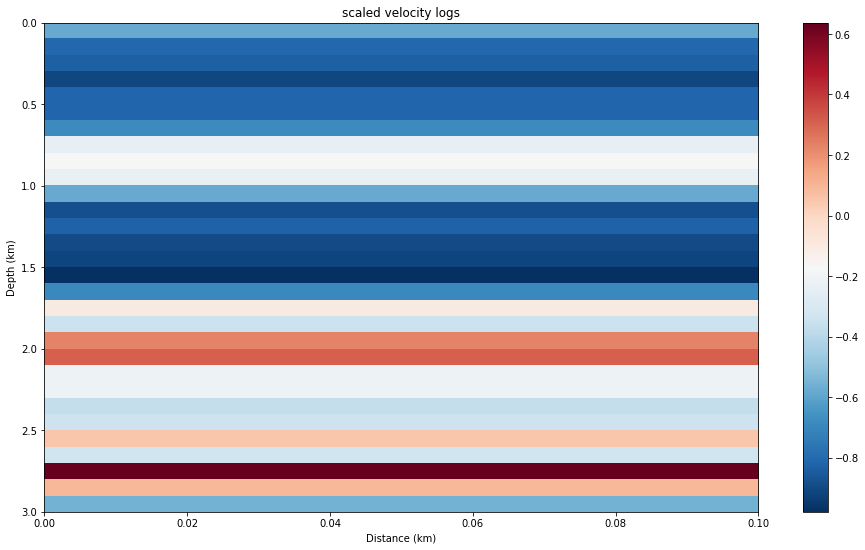

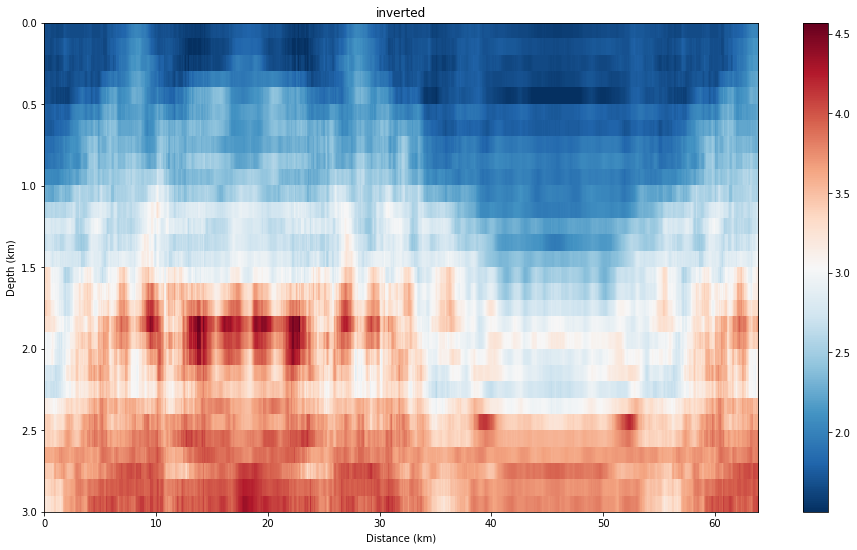

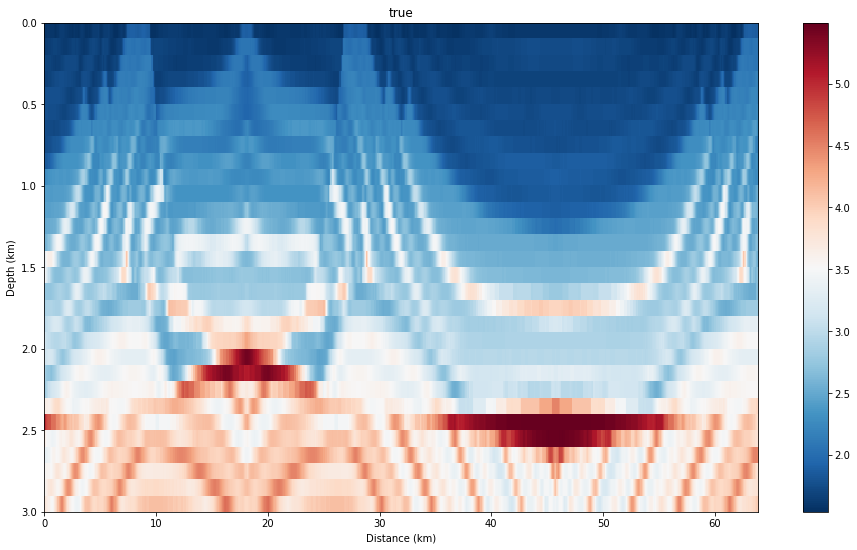

cp: 'marmvel.hh' and 'marmvel.hh' are the same file

vel_test.rsf
(2301, 751)
Model stretched 1 times to 50 meter sampling 

Writing to vel_test.rsf


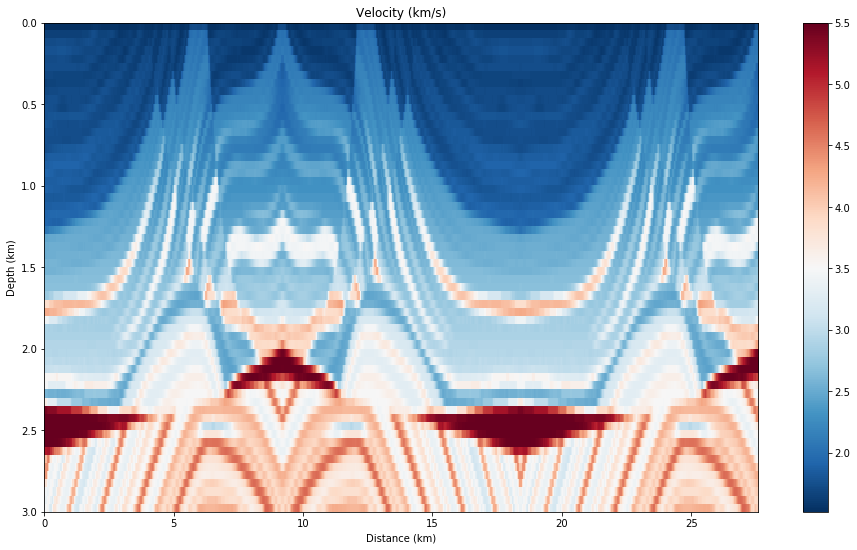

mkdir: cannot create directory ‘marmvel’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 176
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.153929 (s)
sfgenshots: shot 11 finished: 0.029098 (s)
sfgenshots: shot 21 finished: 0.028686 (s)
sfgenshots: shot 31 finished: 0.028954 (s)
sfgenshots: shot 41 finished: 0.028322 (s)
sfgenshots: shot 51 finished: 0.028498 (s)
sfgenshots: shot 61 finished: 0.028485 (s)
sfgenshots: shot 71 finished: 0.029223 (s)
sfgenshots: shot 81 finished: 0.029035 (s)
sfgenshots: shot 91 finished: 0.028343 (s)
sfgenshots: shot 101 finished: 0.028885 (s)
sfgenshots: shot 111 f

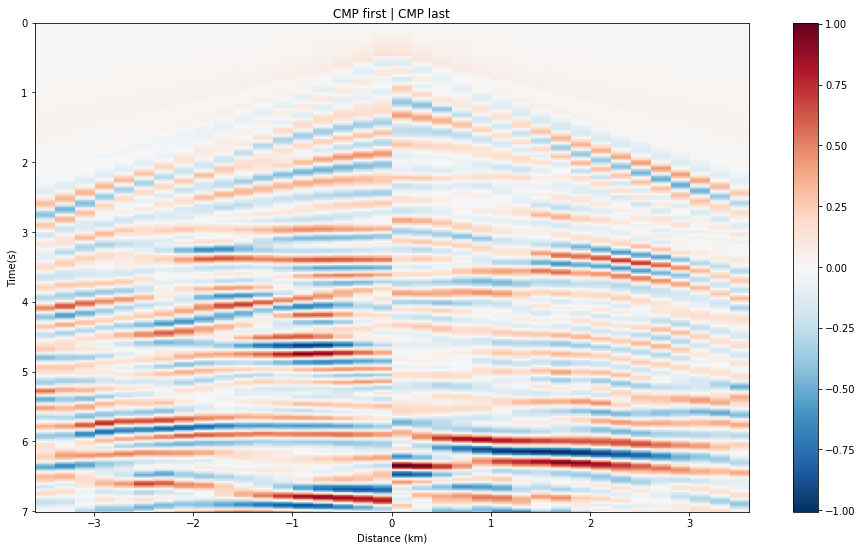

(1, 30)


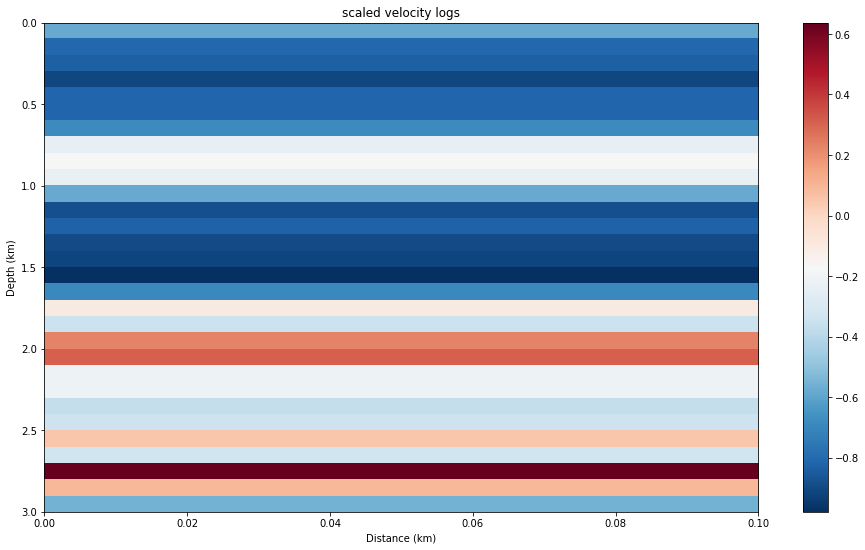

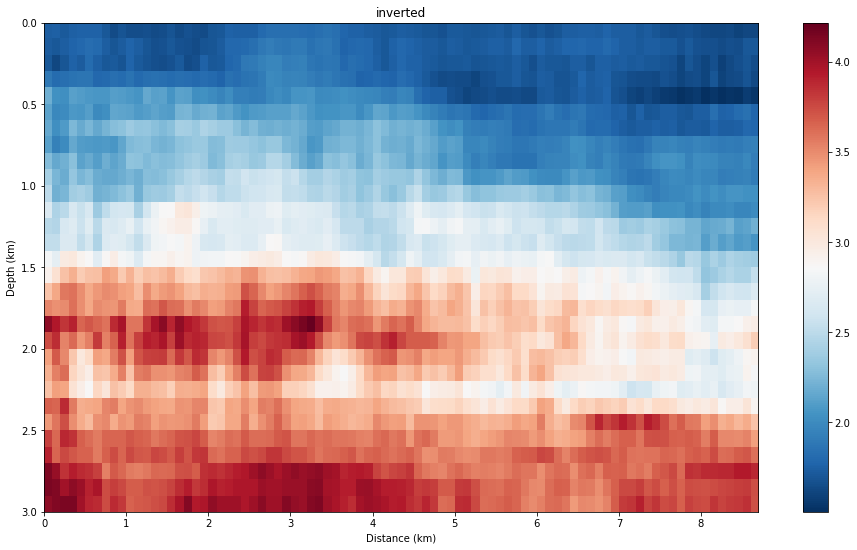

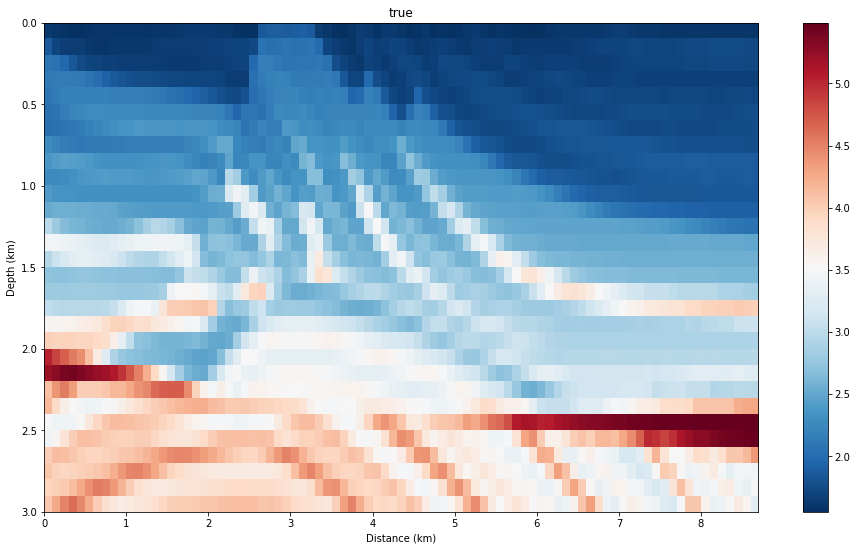

vel_test.rsf
(801, 120)
Model stretched 1 times to 50 meter sampling 

Writing to vel_test.rsf


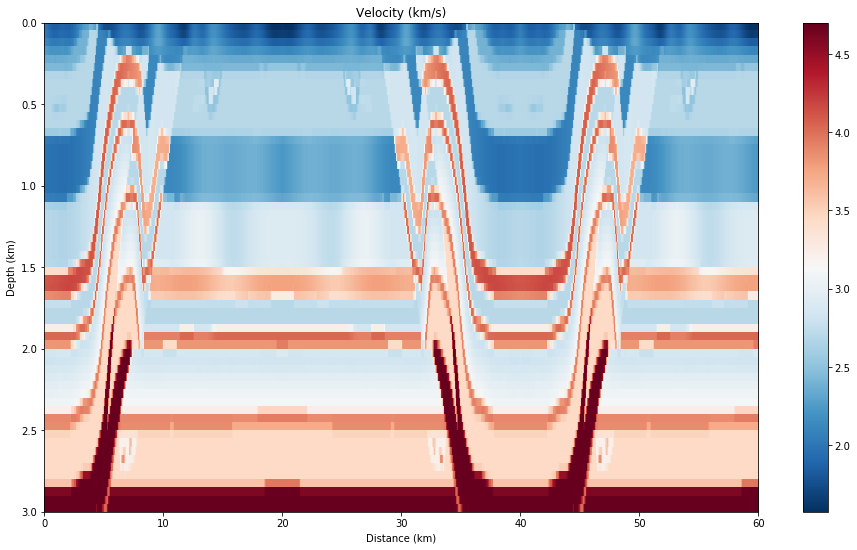

mkdir: cannot create directory ‘overthrust2D’: File exists


you chose dt = 0.0025, dt < 0.0091 should be chosen for stability 

Total number of shots = 500
:
GPU0:	TITAN RTX	7.5: No such file or directory
: 	24 GB:	 total Global memory (gmem)
: 	64 MB:	 total Constant memory (cmem)
: 	48 MB:	 total Shared memory per block (smem)
: 	1024:	 total threads per block
: 	65536:	 total registers per block
: 	32:	 warp size
: 	1024 x 1024 x 64:	 max dims of block
: 	2147483647 x 65535 x 65535:	 max dims of grid
sfgenshots: shot 1 finished: 0.087995 (s)
sfgenshots: shot 11 finished: 0.040939 (s)
sfgenshots: shot 21 finished: 0.041016 (s)
sfgenshots: shot 31 finished: 0.040925 (s)
sfgenshots: shot 41 finished: 0.040900 (s)
sfgenshots: shot 51 finished: 0.041054 (s)
sfgenshots: shot 61 finished: 0.041007 (s)
sfgenshots: shot 71 finished: 0.041086 (s)
sfgenshots: shot 81 finished: 0.041014 (s)
sfgenshots: shot 91 finished: 0.041082 (s)
sfgenshots: shot 101 finished: 0.041025 (s)
sfgenshots: shot 

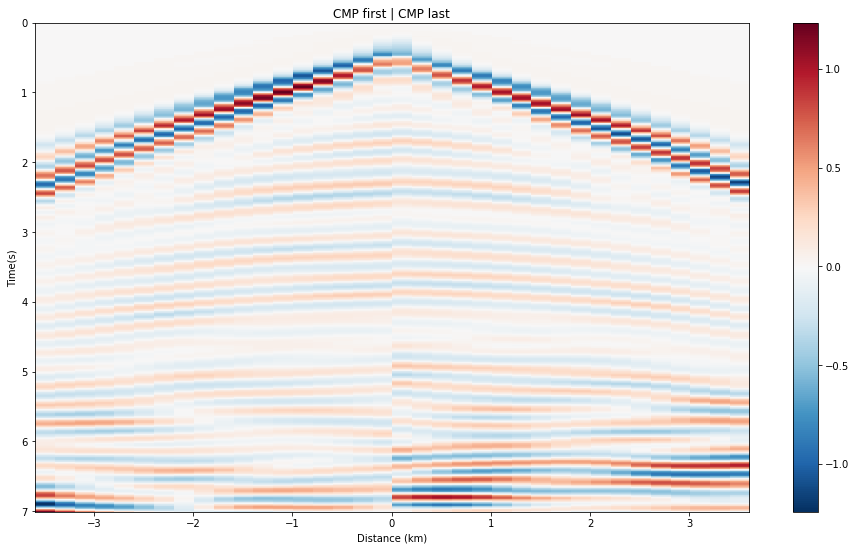

(1, 30)


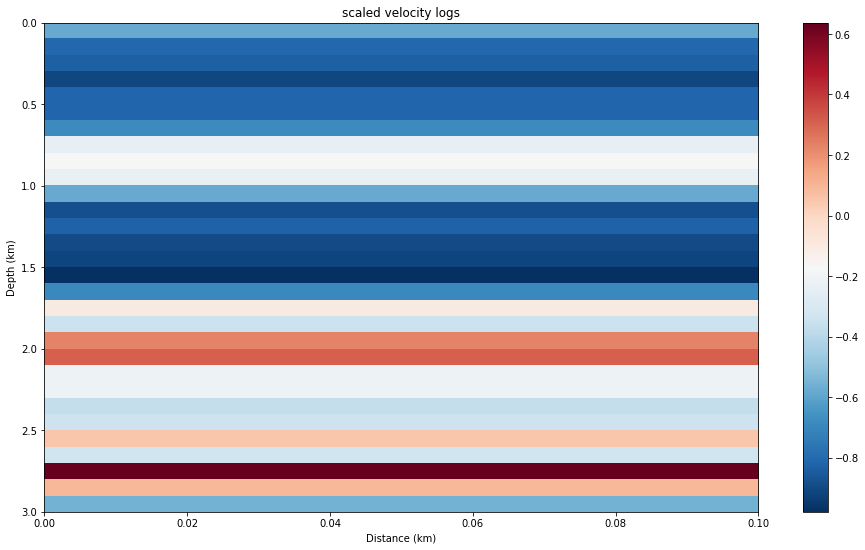

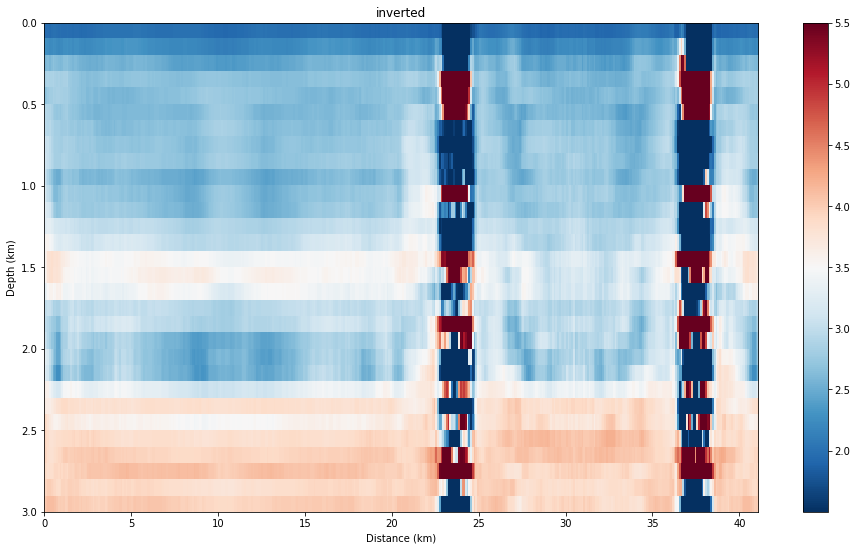

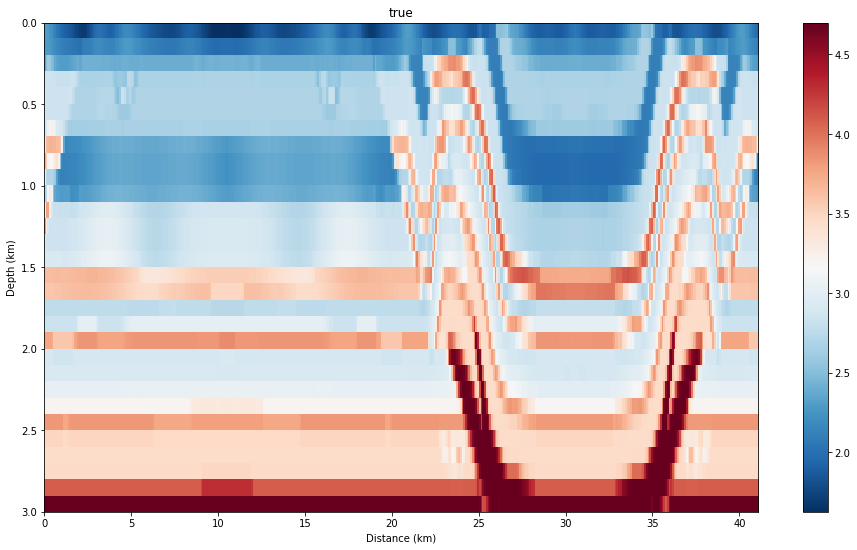

In [19]:
def run_all_tests(net=singleCMP_net, prefix="single"):
    print(type(singleCMP_net))
    test_on_model("marmvel1D", net=net, prefix=prefix)

    # Test on a distorted 1D profile from Marmousi

    cmd("cp marmvel1D.hh marmvel1D_distort.hh")
    test_on_model("marmvel1D_distort", net=net, prefix=prefix, distort_flag=True)

    # Testing on Overthrust 1D part model
    test_on_model("overthrust1D", net=net, prefix=prefix)

    # Test on different stretched versions of Marmousi
    # cmd("cp marmvel.hh marmvel_x6.hh")
    # test_on_model("marmvel_x6", net=net, prefix=prefix, stretch_X=6)

    cmd("cp marmvel.hh marmvel_x3.hh")
    test_on_model("marmvel_x3", net=net, prefix=prefix, stretch_X=3)

    cmd("cp marmvel.hh marmvel.hh")
    test_on_model("marmvel", net=net, prefix=prefix, stretch_X=1)

    # Test on Overthrust 2D model (FAIL)
    test_on_model("overthrust2D", net=net, prefix=prefix, stretch_X=1)

    # cmd("cp overthrust2D.hh overthrust2D_x3.hh")
    # test_on_model("overthrust2D", net=net, prefix=prefix, stretch_X=3)

run_all_tests(net=singleCMP_net, prefix="singleCMP")

run_all_tests(net=multiCMP_net, prefix="multiCMP")
    # Test the multi-CMP model